1 Year Data

1. 5args
2. 7args
3. 加大盤
4. 加買超賣超


*   5/20
*   10/20
*   20/10







Libraries

In [86]:
import pandas as pd
import numpy as np
import joblib
import math
import os
from tqdm import tqdm
from datetime import datetime, timedelta
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from google.colab import drive

drive.mount('/content/drive')

FIVE_ARGS = ['Open', 'Close', 'High', 'Low', 'Volume']
SIX_ARGS = ['Open', 'Close', 'High', 'Low', 'Volume', 'II']
SEVEN_ARGS = ['Open', 'Close', 'High', 'Low', 'Volume', 'SMA', 'BIAS']
EIGHT_ARGS = ['Open', 'Close', 'High', 'Low', 'Volume', 'SMA', 'BIAS', 'II']

home = '/content/drive/MyDrive/ML_Project/final/'
input_dir = '0050-1224'
params_dir = 'final_model_params'
predict_start_day = datetime(2023, 12, 18)
output_dir = f'predict_{predict_start_day.year}{predict_start_day.month}{predict_start_day.day}'

SMA_num = 20
predict_num = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read final model csv and initialize directory


In [87]:
company_list = ['智邦', '中信金', '統一超', '玉山金', '鴻海', '日月光投控', '亞德客-KY', '瑞昱', '中鋼', '聯發科', '大立光', '南亞科', '台泥', '緯創', '兆豐金', '合庫金', '和碩', '第一金', '遠傳', '豐泰', '富邦金', '台積電', '永豐金', '元大金', '台塑', '欣興', '開發金', '和泰車', '統一', '長榮', '緯穎', '廣達', '上海商銀', '台塑化', '南亞', '國巨', '中租-KY', '華南金', '彰銀', '台新金', '國泰金', '研華', '華碩', '聯詠', '台化', '台灣大', '中華電', '光寶科', '聯電', '台達電']
company_list = company_list[:]

final_model = pd.read_csv(home + 'final_model.csv')
final_model.columns = ['company', 'input', 'args', 'mse', 'model', 'days' , 'comment1', 'start', 'comment2']
final_model = final_model.drop(['mse', 'comment1', 'comment2'], axis=1).loc[1:, :].reset_index(drop=True)
# print(final_model)

if output_dir not in os.listdir(home):
  os.mkdir(home+output_dir)

for company in company_list:
  if company not in os.listdir(home+output_dir):
    os.mkdir(home+output_dir+'/'+company)
  for f in os.listdir(home+output_dir+'/'+company):
    os.remove(home+output_dir+'/'+company+'/'+f)

output_path = home + output_dir + '/'

Input CSV File

In [88]:
company_df_dict = {}
for company in company_list:
  # print(company)

  df = pd.read_csv(home+input_dir+'/'+company+'/K_Chart.csv')
  df = df.iloc[2:, :16]
  df = df.drop(['漲跌','漲跌.1','振幅','Unnamed: 9','Unnamed: 10','Unnamed: 11','法人買賣超(張)','Unnamed: 13','Unnamed: 14'],axis=1)
  df.columns = ['Date','Open','High','Low','Close','Volume','II']
  df['Date'] = df['Date'].apply(lambda x: '2023年'+str(x))
  df['Date'] = pd.to_datetime(df['Date'].values, format='%Y年%m月%d日')
  df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(',','')))
  df['II'] = df['II'].apply(lambda x: float(str(x).replace(',','')))
  df = df.iloc[::-1].reset_index(drop=True)

  if int(final_model.loc[final_model['company'] == company, 'args'].values[0]) == 5 or int(final_model.loc[final_model['company'] == company, 'args'].values[0]) == 7:
    df = df.drop(['II'], axis=1)
  if int(final_model.loc[final_model['company'] == company, 'args'].values[0]) >= 7:
    SMA = []
    BIAS = []
    for i in range(len(df)):
      if i < SMA_num - 1:
        SMA.append(0)
        BIAS.append(0)
      else:
        SMA.append(df.loc[i+1-SMA_num:i+1, 'Open'].mean())
        BIAS.append((df.loc[i, 'Open'] - SMA[i]) / SMA[i])
    df['SMA'] = SMA
    df['BIAS'] = BIAS
    df = df.loc[SMA_num:].reset_index(drop=True)

  # print(df.head(10))

  company_df_dict[company] = df

Functions

In [89]:
def Get_Dataset(df, input_num):
  X_pred = []

  for predict_pre in range(len(df)):
    if predict_pre == len(df) - 1:
      break
    if df.loc[predict_pre, 'Date'] < predict_start_day and df.loc[predict_pre+1, 'Date'] >= predict_start_day:
      break

  start_index = predict_pre - input_num - predict_num + 2
  df = df.drop(['Date'],axis=1)

  for i in range(start_index, start_index+predict_num):
    X_pred.append(df.loc[i:i+input_num-1].values)

  return np.array(X_pred)

def get_statistic(df_prediction):
  df_prediction = df_prediction.reset_index(drop=True)
  ae, se = 0.0, 0.0
  for i in range(len(df_prediction)):
    ae += df_prediction.loc[i,'Open'] - df_prediction.loc[i,'Prediction'] if df_prediction.loc[i,'Open'] > df_prediction.loc[i,'Prediction'] else  df_prediction.loc[i,'Prediction'] - df_prediction.loc[i,'Open']
    se += (df_prediction.loc[i,'Open'] - df_prediction.loc[i,'Prediction']) ** 2
  return ae / len(df_prediction), se / len(df_prediction)

Main

  0%|          | 0/50 [00:00<?, ?it/s]


智邦

1/1 [==============================] - 1s 770ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 26234 (\N{CJK UNIFIED IDEOGRAPH-667A}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37030 (\N{CJK UNIFIED IDEOGRAPH-90A6}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
  2%|▏         | 1/50 [00:01<01:29,  1.82s/it]


中信金

1/1 [==============================] - 1s 792ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
  4%|▍         | 2/50 [00:03<01:26,  1.81s/it]


統一超

1/1 [==============================] - 1s 770ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 32113 (\N{CJK UNIFIED IDEOGRAPH-7D71}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 36229 (\N{CJK UNIFIED IDEOGRAPH-8D85}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
  6%|▌         | 3/50 [00:05<01:25,  1.82s/it]


玉山金

1/1 [==============================] - 1s 760ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 29577 (\N{CJK UNIFIED IDEOGRAPH-7389}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
  8%|▊         | 4/50 [00:07<01:21,  1.78s/it]


鴻海

1/1 [==============================] - 1s 766ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 40251 (\N{CJK UNIFIED IDEOGRAPH-9D3B}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 10%|█         | 5/50 [00:09<01:22,  1.84s/it]


日月光投控

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 12%|█▏        | 6/50 [00:11<01:31,  2.07s/it]


亞德客-KY

1/1 [==============================] - 1s 1000ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 24503 (\N{CJK UNIFIED IDEOGRAPH-5FB7}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 14%|█▍        | 7/50 [00:14<01:39,  2.32s/it]


瑞昱

1/1 [==============================] - 1s 815ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 29790 (\N{CJK UNIFIED IDEOGRAPH-745E}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 26161 (\N{CJK UNIFIED IDEOGRAPH-6631}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 16%|█▌        | 8/50 [00:16<01:31,  2.18s/it]


中鋼

1/1 [==============================] - 1s 758ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37628 (\N{CJK UNIFIED IDEOGRAPH-92FC}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 18%|█▊        | 9/50 [00:18<01:24,  2.06s/it]


聯發科

1/1 [==============================] - 1s 789ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 32879 (\N{CJK UNIFIED IDEOGRAPH-806F}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 30332 (\N{CJK UNIFIED IDEOGRAPH-767C}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 20%|██        | 10/50 [00:19<01:19,  1.98s/it]


大立光

1/1 [==============================] - 1s 789ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31435 (\N{CJK UNIFIED IDEOGRAPH-7ACB}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 22%|██▏       | 11/50 [00:21<01:15,  1.94s/it]


南亞科

1/1 [==============================] - 1s 770ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 24%|██▍       | 12/50 [00:23<01:12,  1.90s/it]


台泥

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 27877 (\N{CJK UNIFIED IDEOGRAPH-6CE5}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 26%|██▌       | 13/50 [00:25<01:15,  2.05s/it]


緯創

1/1 [==============================] - 2s 2s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21109 (\N{CJK UNIFIED IDEOGRAPH-5275}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 28%|██▊       | 14/50 [00:29<01:26,  2.40s/it]


兆豐金

1/1 [==============================] - 1s 779ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20806 (\N{CJK UNIFIED IDEOGRAPH-5146}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 35920 (\N{CJK UNIFIED IDEOGRAPH-8C50}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 30%|███       | 15/50 [00:30<01:17,  2.21s/it]


合庫金

1/1 [==============================] - 1s 754ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 24235 (\N{CJK UNIFIED IDEOGRAPH-5EAB}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 32%|███▏      | 16/50 [00:32<01:10,  2.07s/it]


和碩

1/1 [==============================] - 1s 758ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 30889 (\N{CJK UNIFIED IDEOGRAPH-78A9}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 34%|███▍      | 17/50 [00:34<01:04,  1.97s/it]


第一金

1/1 [==============================] - 1s 783ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 36%|███▌      | 18/50 [00:36<01:00,  1.90s/it]


遠傳

1/1 [==============================] - 1s 724ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 36960 (\N{CJK UNIFIED IDEOGRAPH-9060}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20659 (\N{CJK UNIFIED IDEOGRAPH-50B3}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 38%|███▊      | 19/50 [00:37<00:57,  1.84s/it]


豐泰

1/1 [==============================] - 2s 2s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 35920 (\N{CJK UNIFIED IDEOGRAPH-8C50}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 27888 (\N{CJK UNIFIED IDEOGRAPH-6CF0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 40%|████      | 20/50 [00:40<01:04,  2.13s/it]


富邦金

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,8))
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 23500 (\N{CJK UNIFIED IDEOGRAPH-5BCC}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37030 (\N{CJK UNIFIED IDEOGRAPH-90A6}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 42%|████▏     | 21/50 [00:43<01:10,  2.43s/it]


台積電

1/1 [==============================] - 1s 811ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 44%|████▍     | 22/50 [00:46<01:05,  2.35s/it]


永豐金

1/1 [==============================] - 1s 778ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 35920 (\N{CJK UNIFIED IDEOGRAPH-8C50}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 46%|████▌     | 23/50 [00:47<00:58,  2.18s/it]


元大金

1/1 [==============================] - 1s 759ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 48%|████▊     | 24/50 [00:49<00:53,  2.05s/it]


台塑

1/1 [==============================] - 1s 771ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 22609 (\N{CJK UNIFIED IDEOGRAPH-5851}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 50%|█████     | 25/50 [00:51<00:48,  1.96s/it]


欣興

1/1 [==============================] - 1s 756ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 27427 (\N{CJK UNIFIED IDEOGRAPH-6B23}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 33288 (\N{CJK UNIFIED IDEOGRAPH-8208}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 52%|█████▏    | 26/50 [00:52<00:45,  1.88s/it]


開發金

1/1 [==============================] - 1s 762ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 38283 (\N{CJK UNIFIED IDEOGRAPH-958B}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 30332 (\N{CJK UNIFIED IDEOGRAPH-767C}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 54%|█████▍    | 27/50 [00:54<00:42,  1.86s/it]


和泰車

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 27888 (\N{CJK UNIFIED IDEOGRAPH-6CF0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 36554 (\N{CJK UNIFIED IDEOGRAPH-8ECA}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 56%|█████▌    | 28/50 [00:57<00:44,  2.04s/it]


統一

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 32113 (\N{CJK UNIFIED IDEOGRAPH-7D71}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 58%|█████▊    | 29/50 [00:59<00:45,  2.15s/it]


長榮

1/1 [==============================] - 1s 833ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 27054 (\N{CJK UNIFIED IDEOGRAPH-69AE}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 60%|██████    | 30/50 [01:02<00:44,  2.25s/it]


緯穎

1/1 [==============================] - 1s 755ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31310 (\N{CJK UNIFIED IDEOGRAPH-7A4E}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 62%|██████▏   | 31/50 [01:03<00:39,  2.10s/it]


廣達

1/1 [==============================] - 1s 747ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 24291 (\N{CJK UNIFIED IDEOGRAPH-5EE3}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 36948 (\N{CJK UNIFIED IDEOGRAPH-9054}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 64%|██████▍   | 32/50 [01:05<00:35,  1.99s/it]


上海商銀

1/1 [==============================] - 1s 760ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37504 (\N{CJK UNIFIED IDEOGRAPH-9280}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 66%|██████▌   | 33/50 [01:07<00:32,  1.91s/it]


台塑化

1/1 [==============================] - 1s 776ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 22609 (\N{CJK UNIFIED IDEOGRAPH-5851}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 68%|██████▊   | 34/50 [01:09<00:30,  1.88s/it]


南亞

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 70%|███████   | 35/50 [01:11<00:29,  1.98s/it]


國巨

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 24040 (\N{CJK UNIFIED IDEOGRAPH-5DE8}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 72%|███████▏  | 36/50 [01:13<00:29,  2.13s/it]


中租-KY

1/1 [==============================] - 1s 830ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31199 (\N{CJK UNIFIED IDEOGRAPH-79DF}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 74%|███████▍  | 37/50 [01:15<00:27,  2.13s/it]


華南金

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 33775 (\N{CJK UNIFIED IDEOGRAPH-83EF}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 76%|███████▌  | 38/50 [01:18<00:26,  2.20s/it]


彰銀

1/1 [==============================] - 1s 798ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 24432 (\N{CJK UNIFIED IDEOGRAPH-5F70}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37504 (\N{CJK UNIFIED IDEOGRAPH-9280}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 78%|███████▊  | 39/50 [01:20<00:22,  2.06s/it]


台新金

1/1 [==============================] - 1s 769ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 80%|████████  | 40/50 [01:21<00:19,  1.98s/it]


國泰金

1/1 [==============================] - 1s 788ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 27888 (\N{CJK UNIFIED IDEOGRAPH-6CF0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 82%|████████▏ | 41/50 [01:23<00:17,  1.93s/it]


研華

1/1 [==============================] - 1s 808ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 30740 (\N{CJK UNIFIED IDEOGRAPH-7814}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 33775 (\N{CJK UNIFIED IDEOGRAPH-83EF}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 84%|████████▍ | 42/50 [01:25<00:15,  1.96s/it]


華碩

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 33775 (\N{CJK UNIFIED IDEOGRAPH-83EF}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 30889 (\N{CJK UNIFIED IDEOGRAPH-78A9}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 86%|████████▌ | 43/50 [01:28<00:14,  2.11s/it]


聯詠

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 32879 (\N{CJK UNIFIED IDEOGRAPH-806F}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 35424 (\N{CJK UNIFIED IDEOGRAPH-8A60}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 88%|████████▊ | 44/50 [01:31<00:15,  2.57s/it]


台化

1/1 [==============================] - 1s 735ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 90%|█████████ | 45/50 [01:33<00:11,  2.31s/it]


台灣大

1/1 [==============================] - 1s 740ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 28771 (\N{CJK UNIFIED IDEOGRAPH-7063}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 92%|█████████▏| 46/50 [01:35<00:09,  2.31s/it]


中華電

1/1 [==============================] - 1s 807ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 33775 (\N{CJK UNIFIED IDEOGRAPH-83EF}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 94%|█████████▍| 47/50 [01:37<00:06,  2.16s/it]


光寶科

1/1 [==============================] - 1s 835ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 23542 (\N{CJK UNIFIED IDEOGRAPH-5BF6}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 96%|█████████▌| 48/50 [01:39<00:04,  2.06s/it]


聯電

1/1 [==============================] - 1s 989ms/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 32879 (\N{CJK UNIFIED IDEOGRAPH-806F}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
 98%|█████████▊| 49/50 [01:41<00:02,  2.09s/it]


台達電

1/1 [==============================] - 1s 1s/step


<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 36948 (\N{CJK UNIFIED IDEOGRAPH-9054}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
<ipython-input-90-c8842c97e3cc>:54: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  plt.savefig(output_path+company+'/plot.png')
100%|██████████| 50/50 [01:45<00:00,  2.10s/it]
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26234 (\N{CJK UNIFIED IDEOGRAPH-667A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37030 (\N{CJK UNIFIED IDEOGRAPH-90A6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


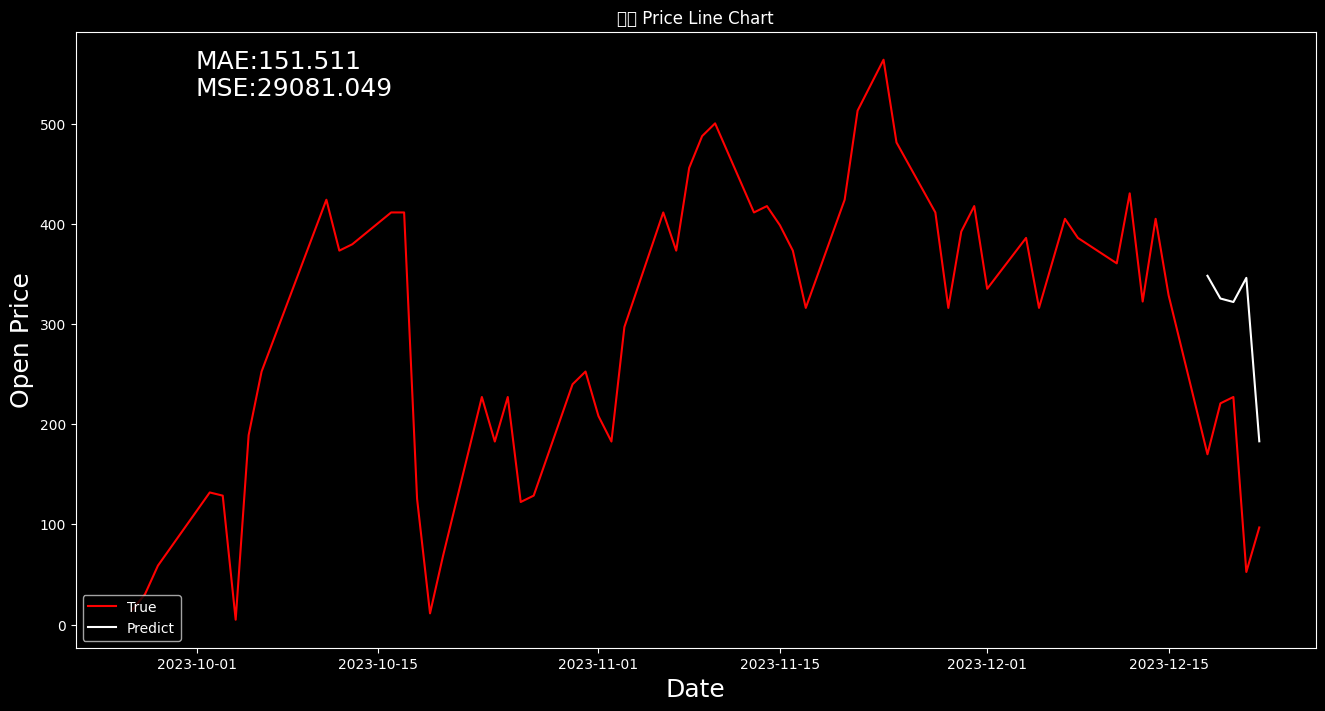

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


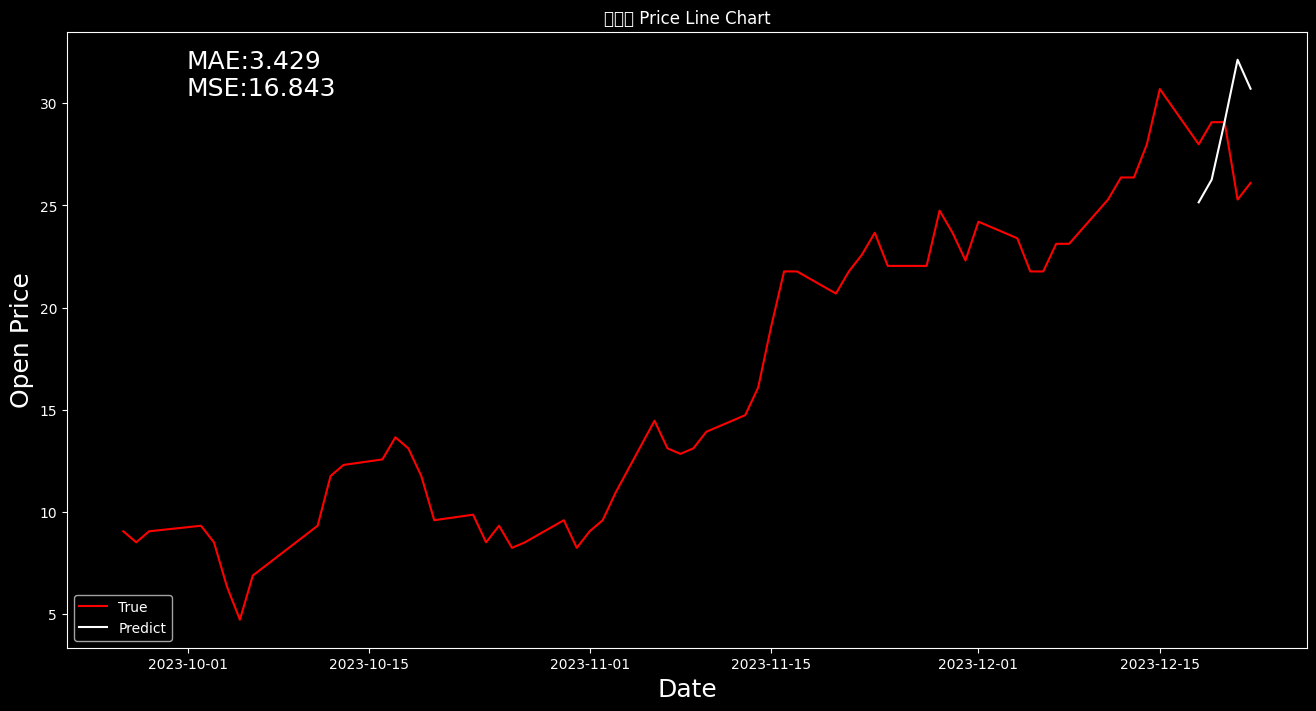

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32113 (\N{CJK UNIFIED IDEOGRAPH-7D71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36229 (\N{CJK UNIFIED IDEOGRAPH-8D85}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


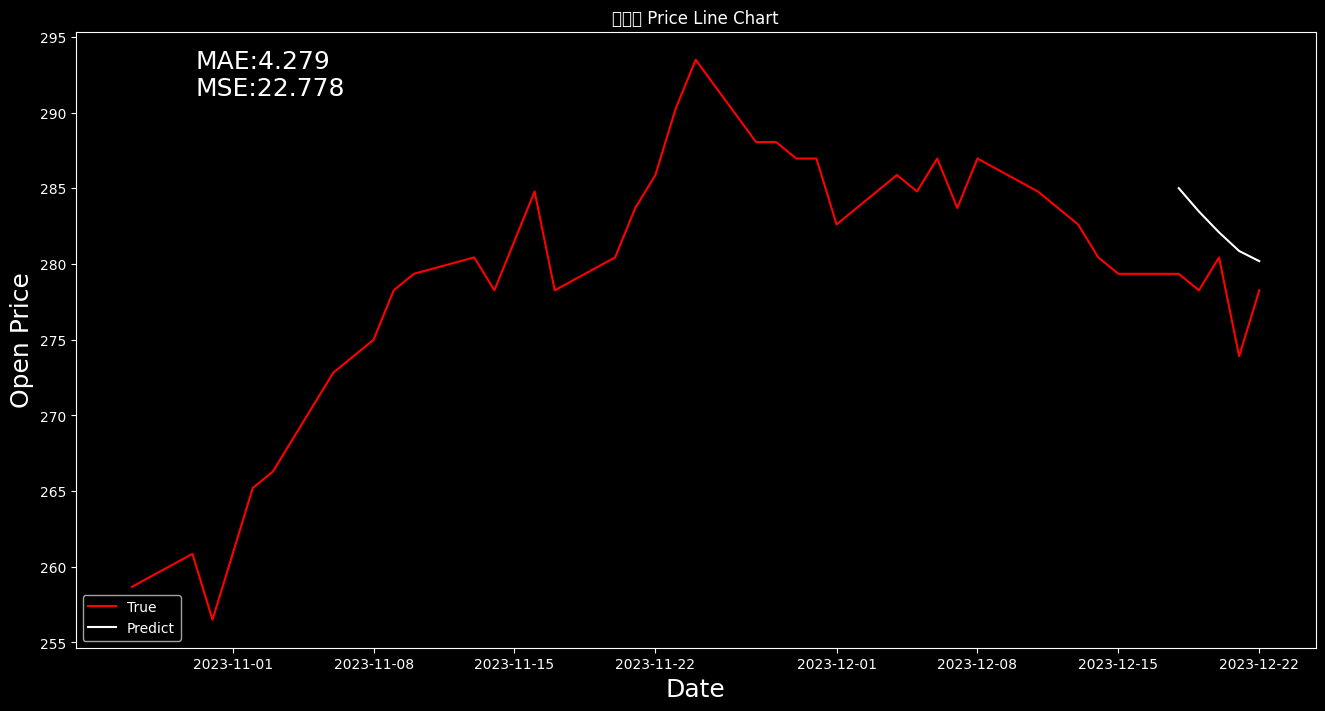

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29577 (\N{CJK UNIFIED IDEOGRAPH-7389}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


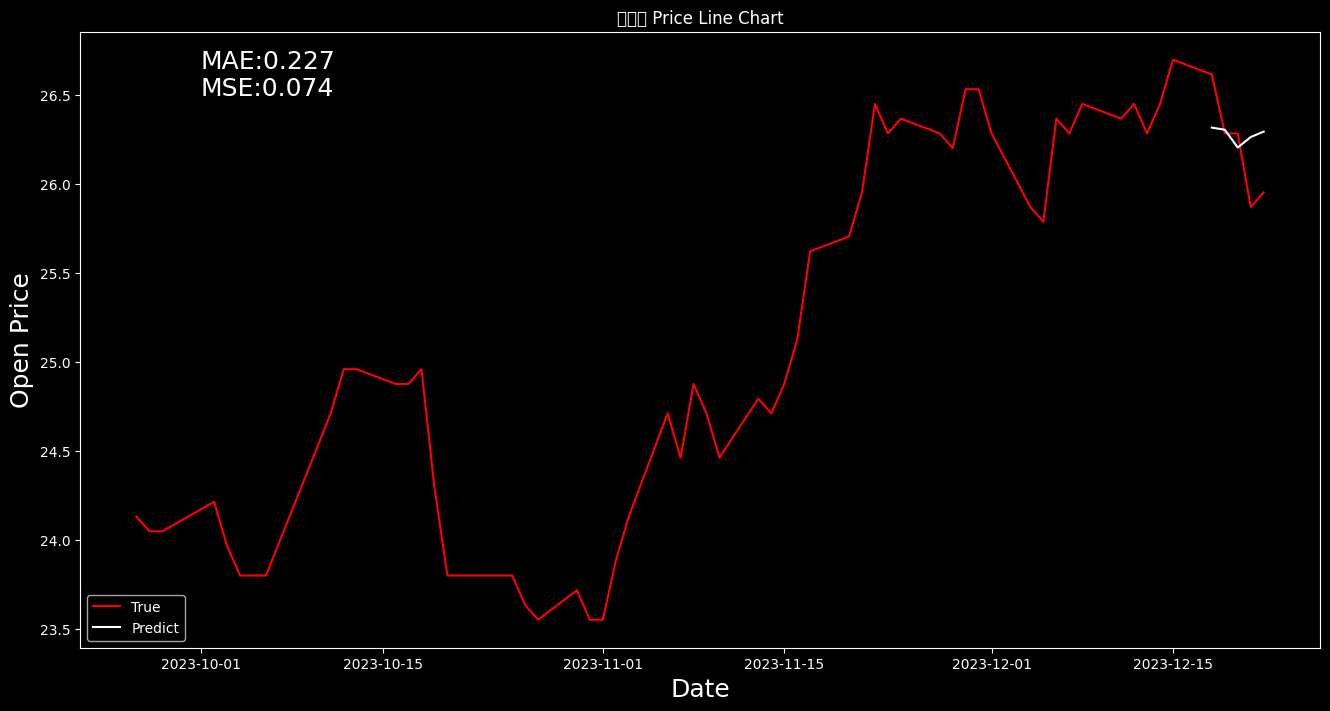

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40251 (\N{CJK UNIFIED IDEOGRAPH-9D3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


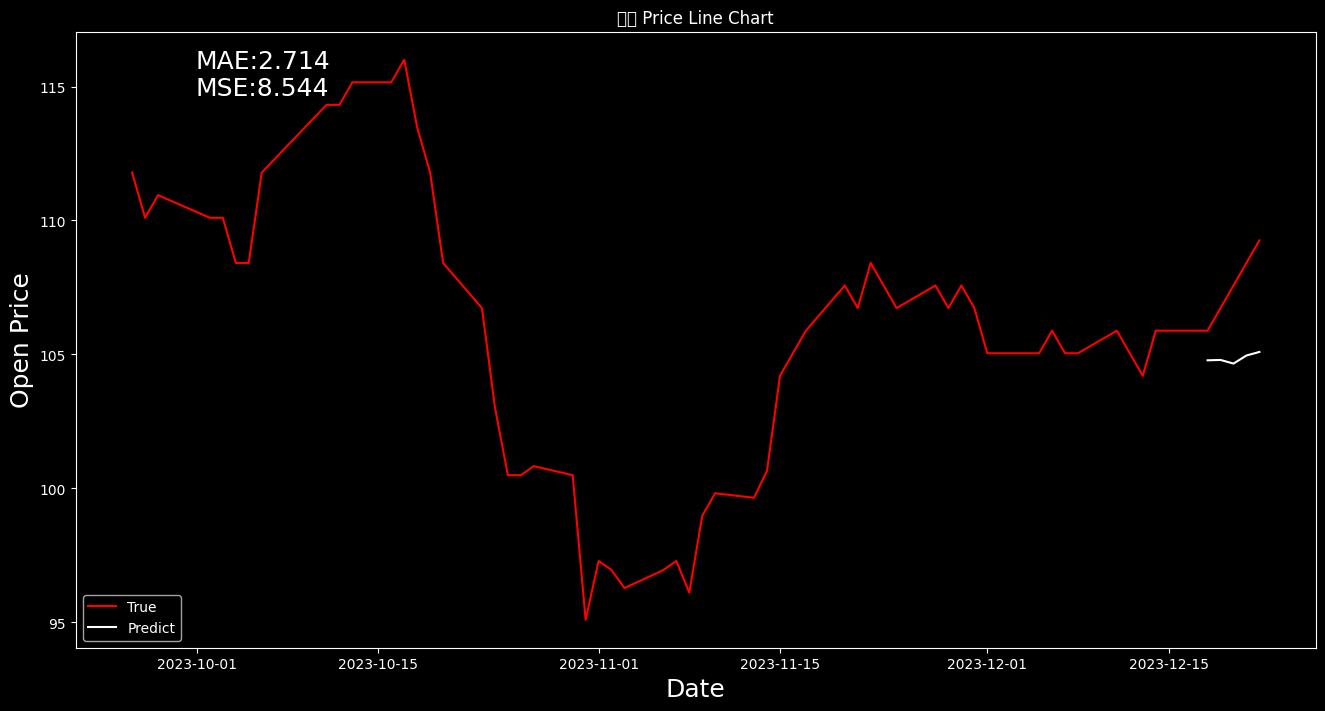

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


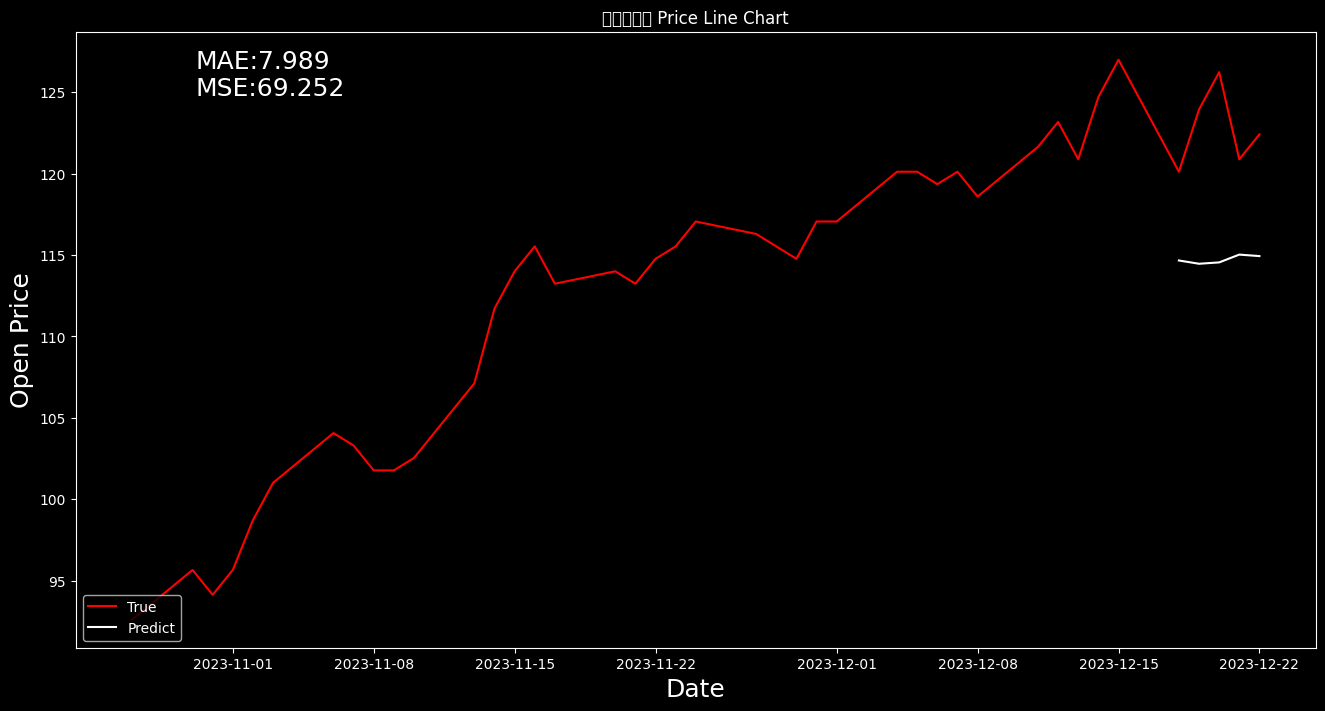

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24503 (\N{CJK UNIFIED IDEOGRAPH-5FB7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


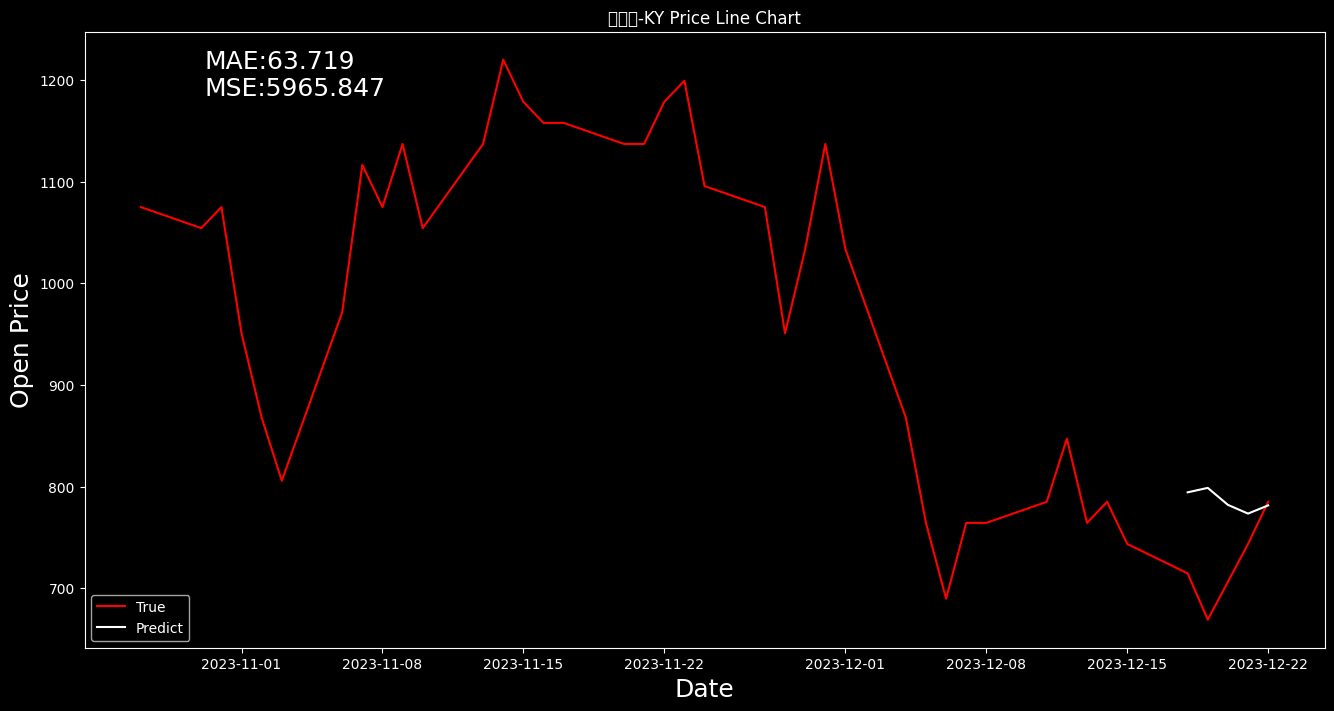

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29790 (\N{CJK UNIFIED IDEOGRAPH-745E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26161 (\N{CJK UNIFIED IDEOGRAPH-6631}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


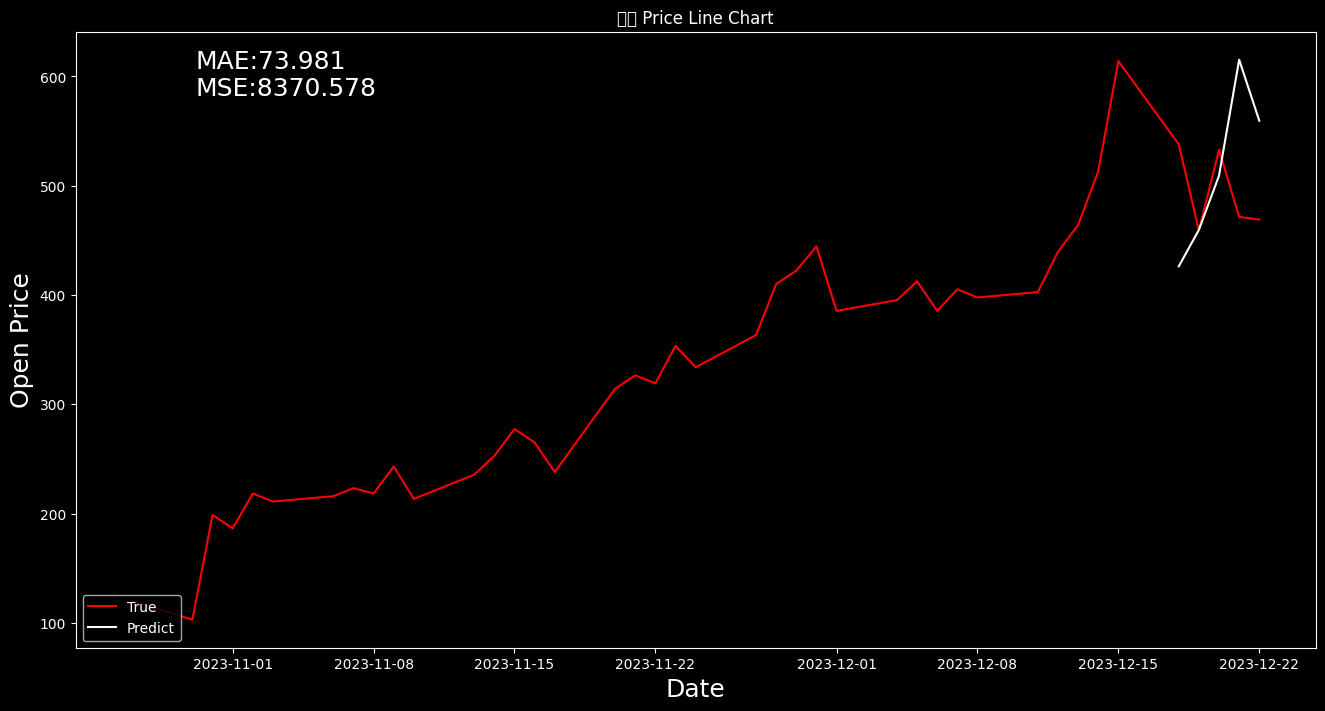

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37628 (\N{CJK UNIFIED IDEOGRAPH-92FC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


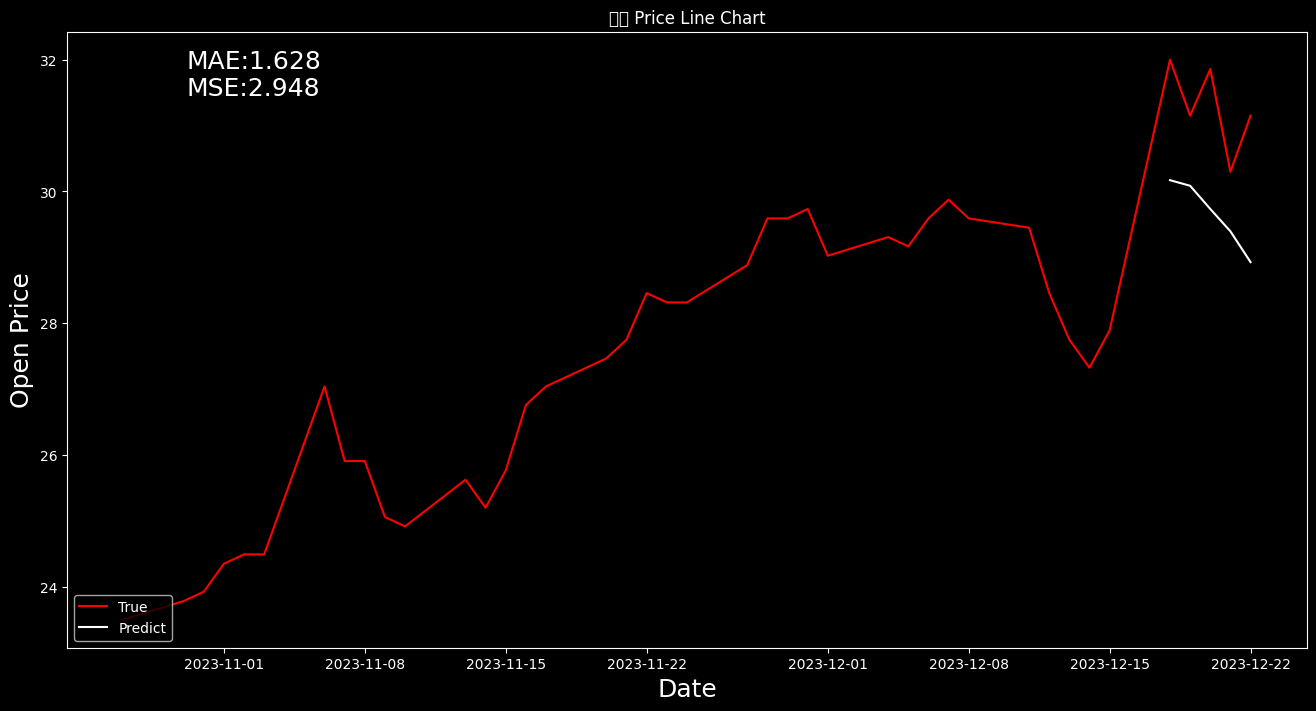

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32879 (\N{CJK UNIFIED IDEOGRAPH-806F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30332 (\N{CJK UNIFIED IDEOGRAPH-767C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


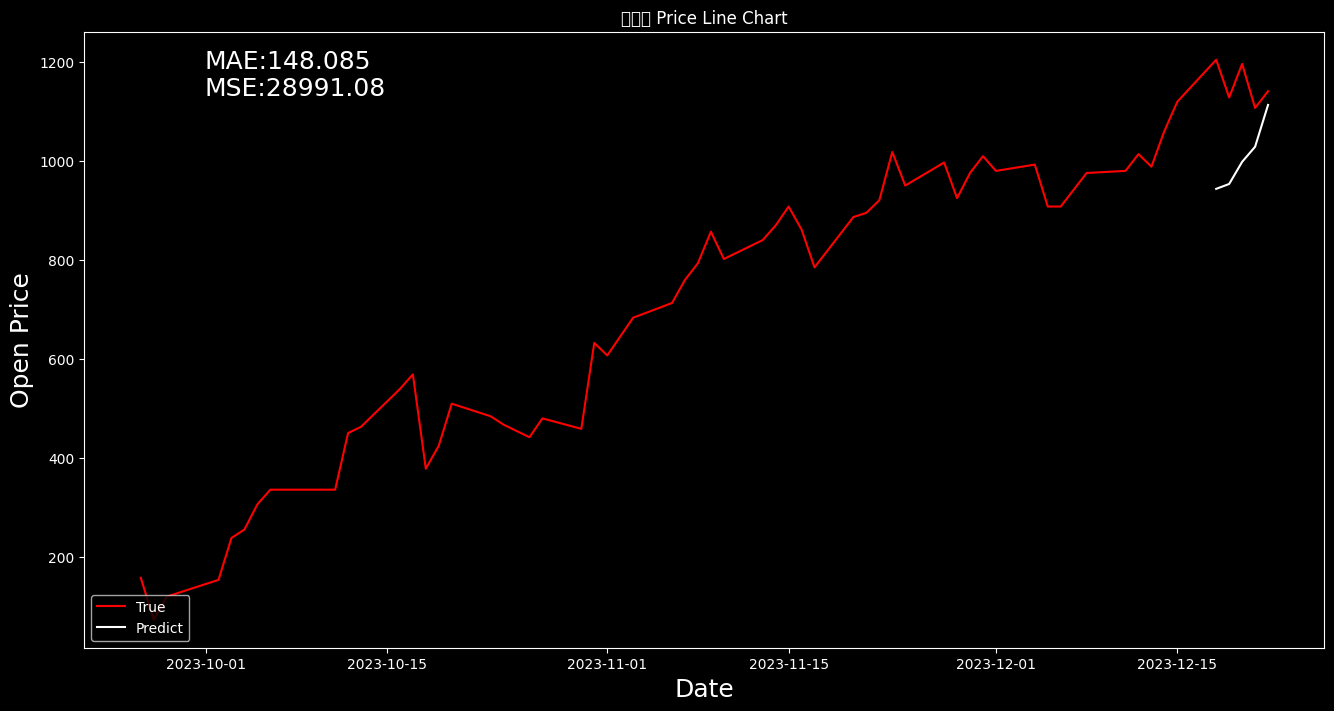

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31435 (\N{CJK UNIFIED IDEOGRAPH-7ACB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


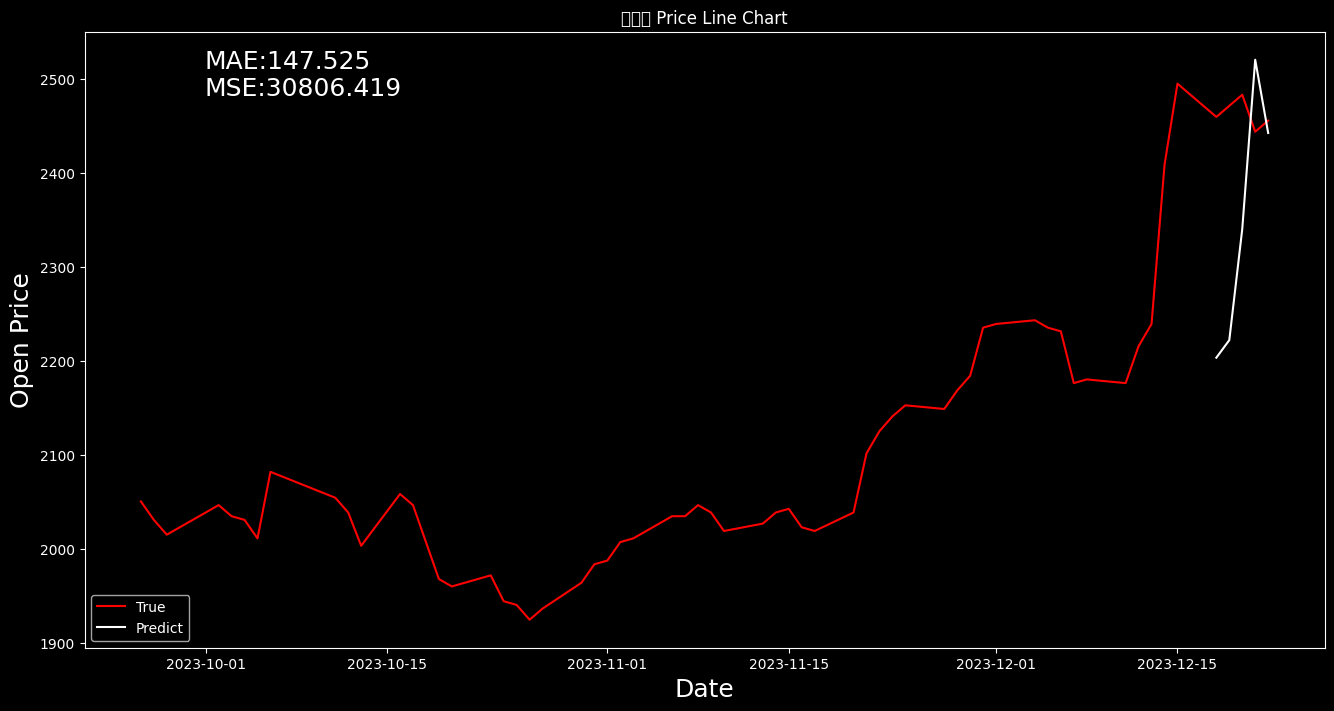

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


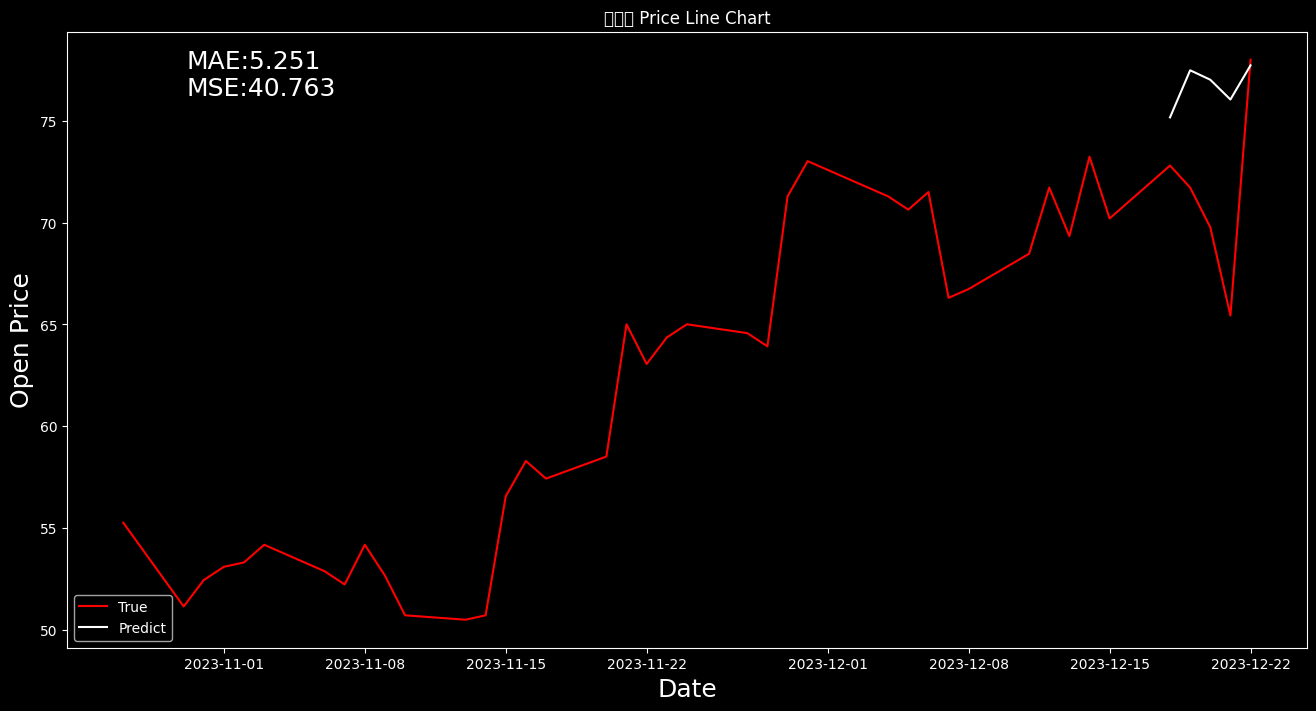

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27877 (\N{CJK UNIFIED IDEOGRAPH-6CE5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


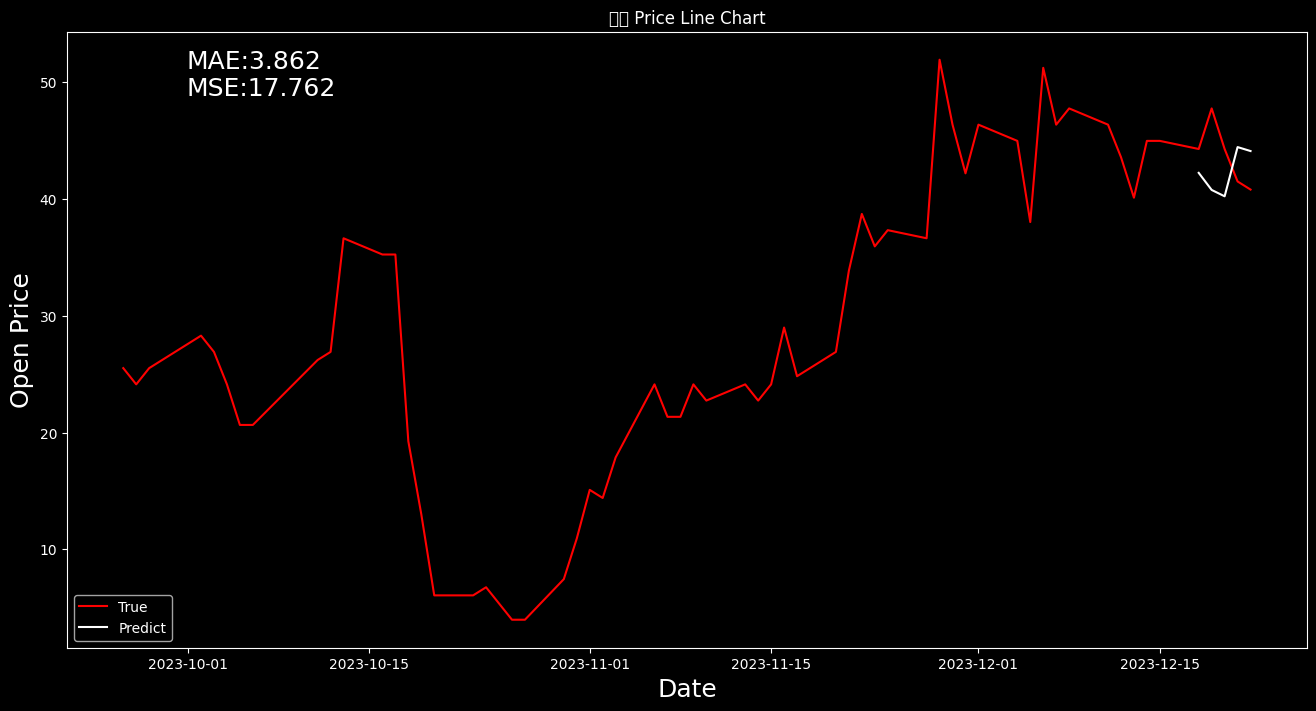

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21109 (\N{CJK UNIFIED IDEOGRAPH-5275}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


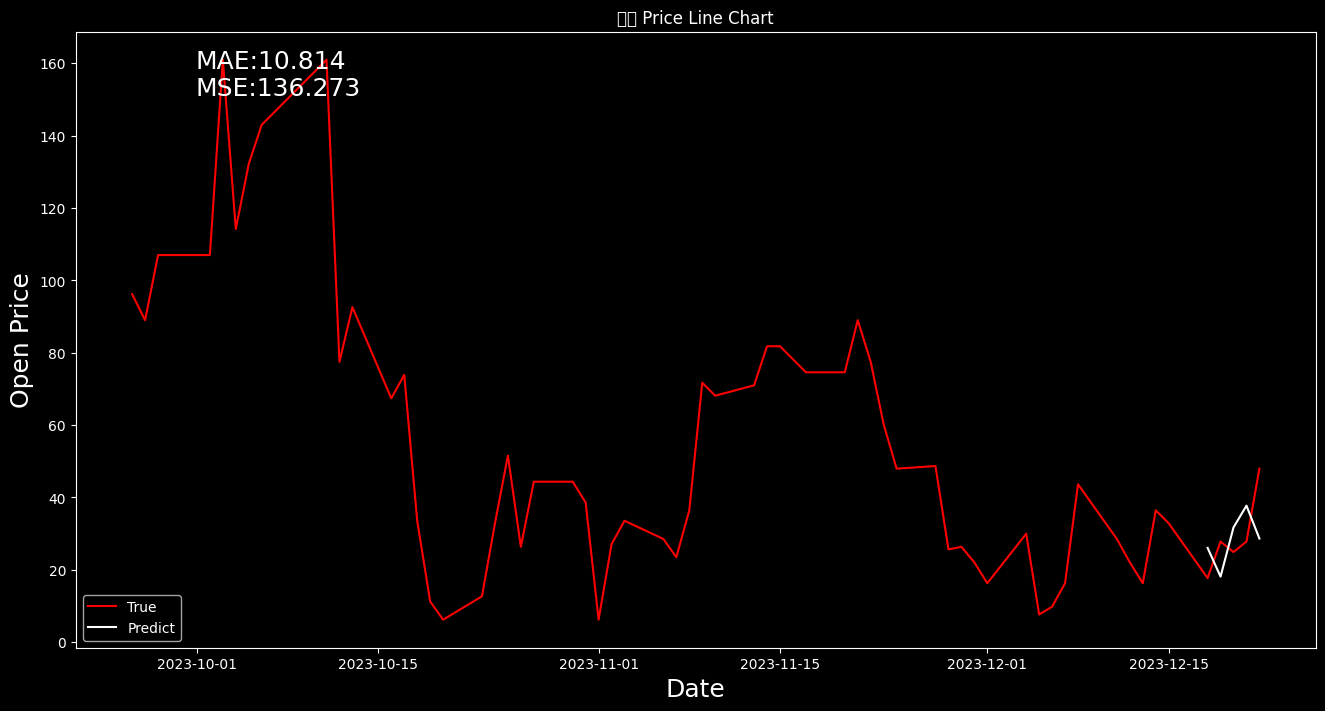

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20806 (\N{CJK UNIFIED IDEOGRAPH-5146}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35920 (\N{CJK UNIFIED IDEOGRAPH-8C50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


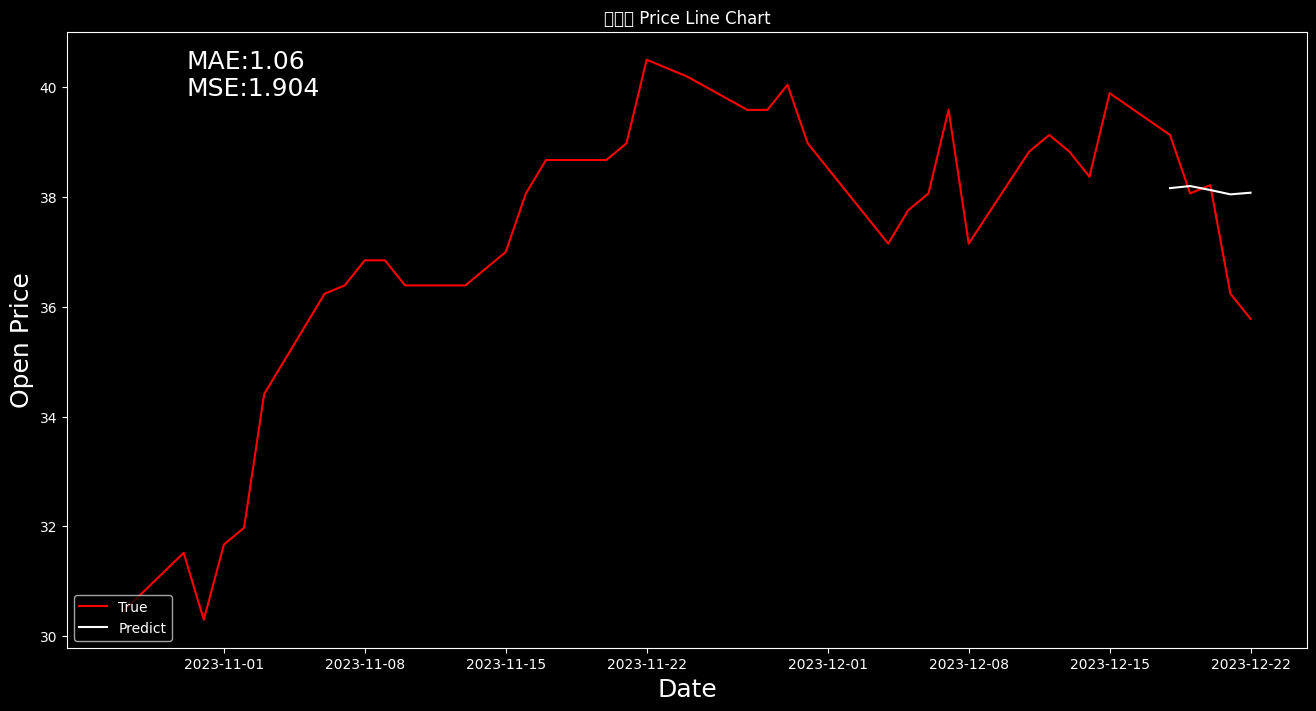

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24235 (\N{CJK UNIFIED IDEOGRAPH-5EAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


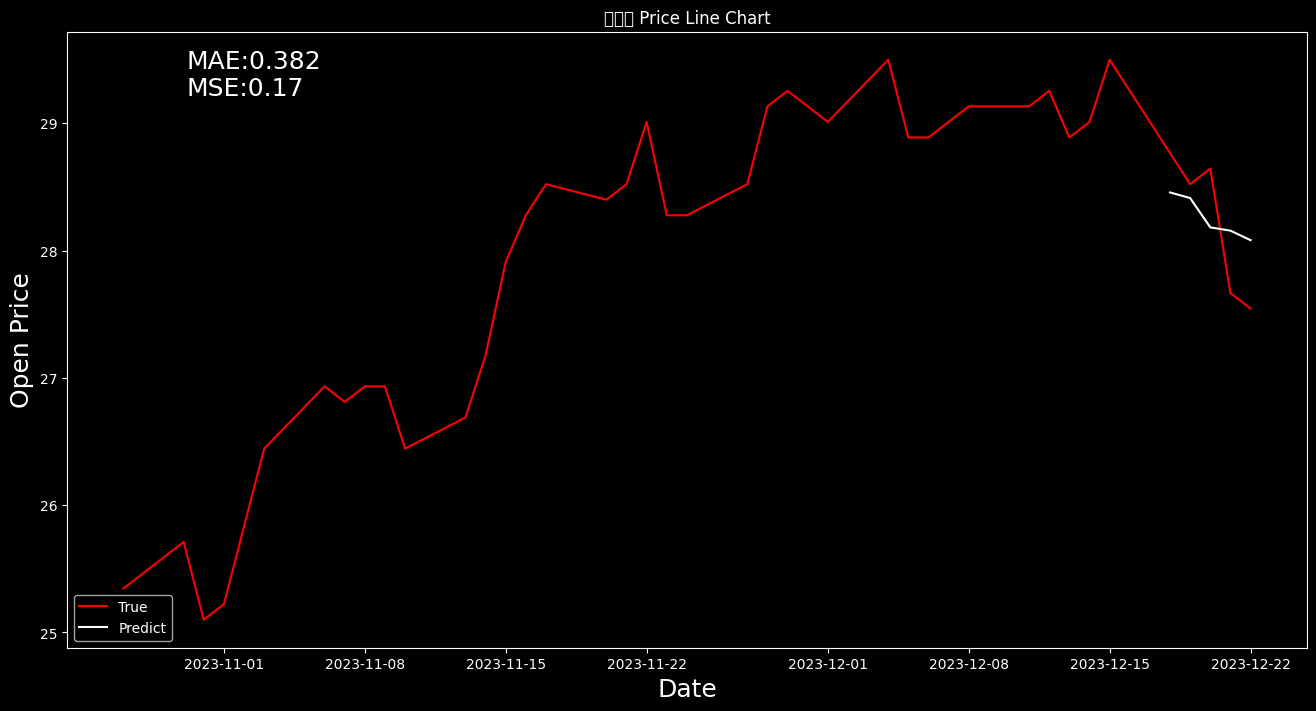

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30889 (\N{CJK UNIFIED IDEOGRAPH-78A9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


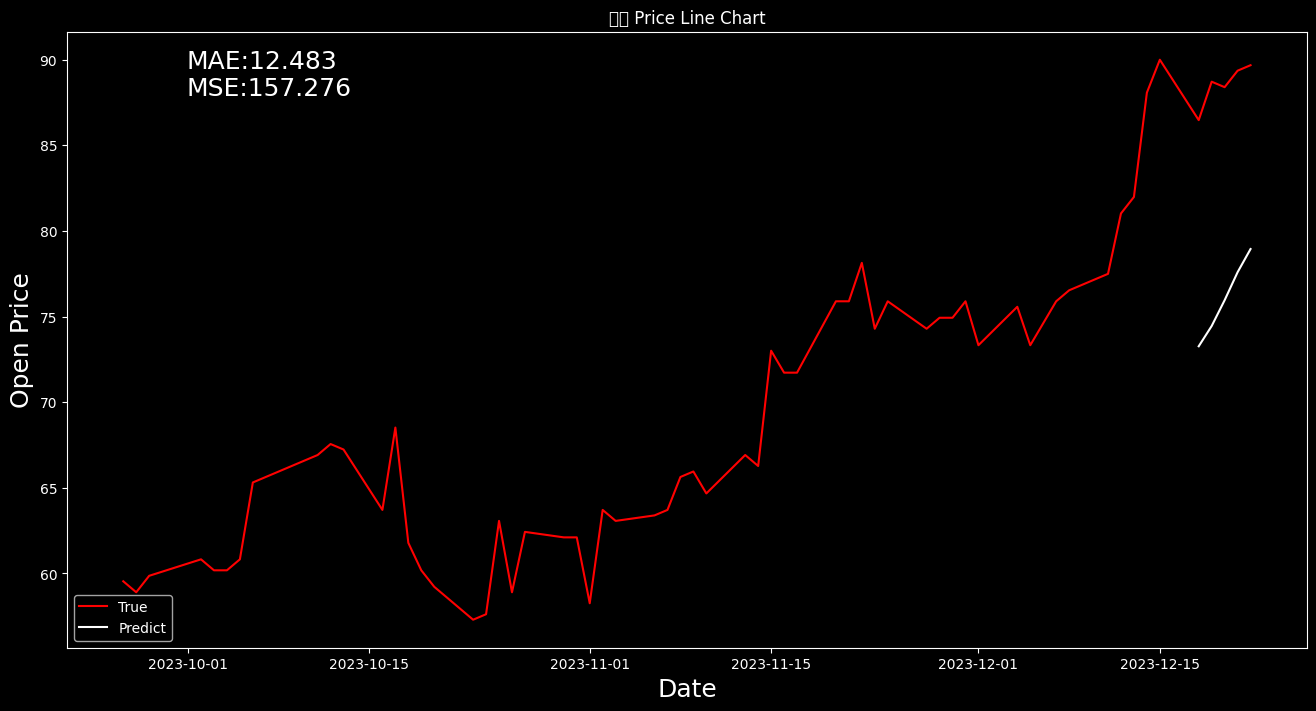

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


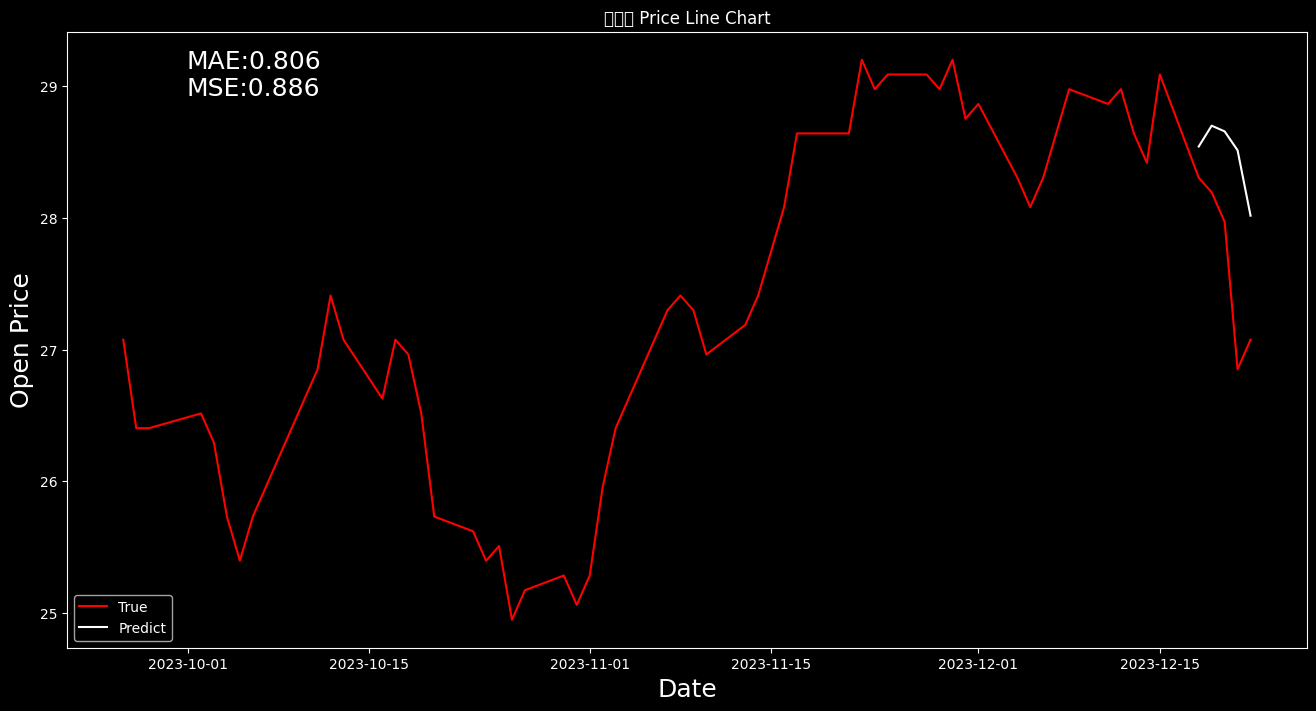

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36960 (\N{CJK UNIFIED IDEOGRAPH-9060}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20659 (\N{CJK UNIFIED IDEOGRAPH-50B3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


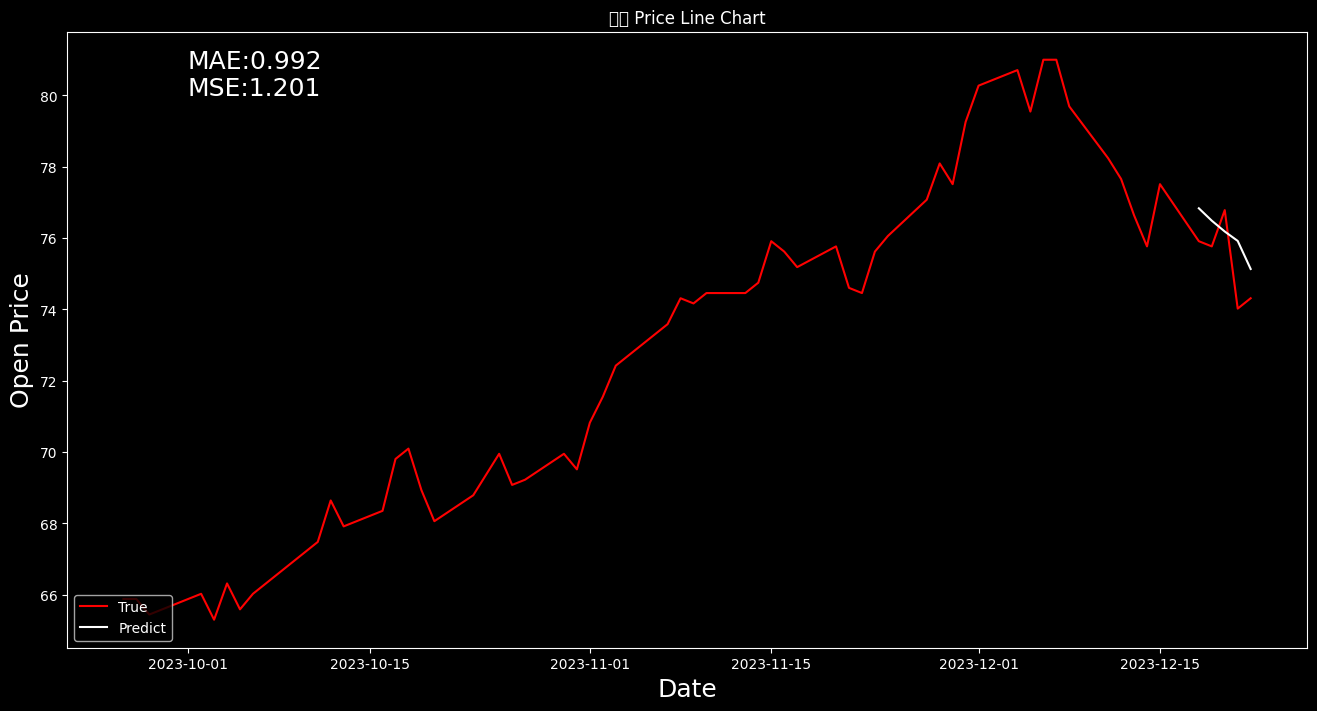

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27888 (\N{CJK UNIFIED IDEOGRAPH-6CF0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


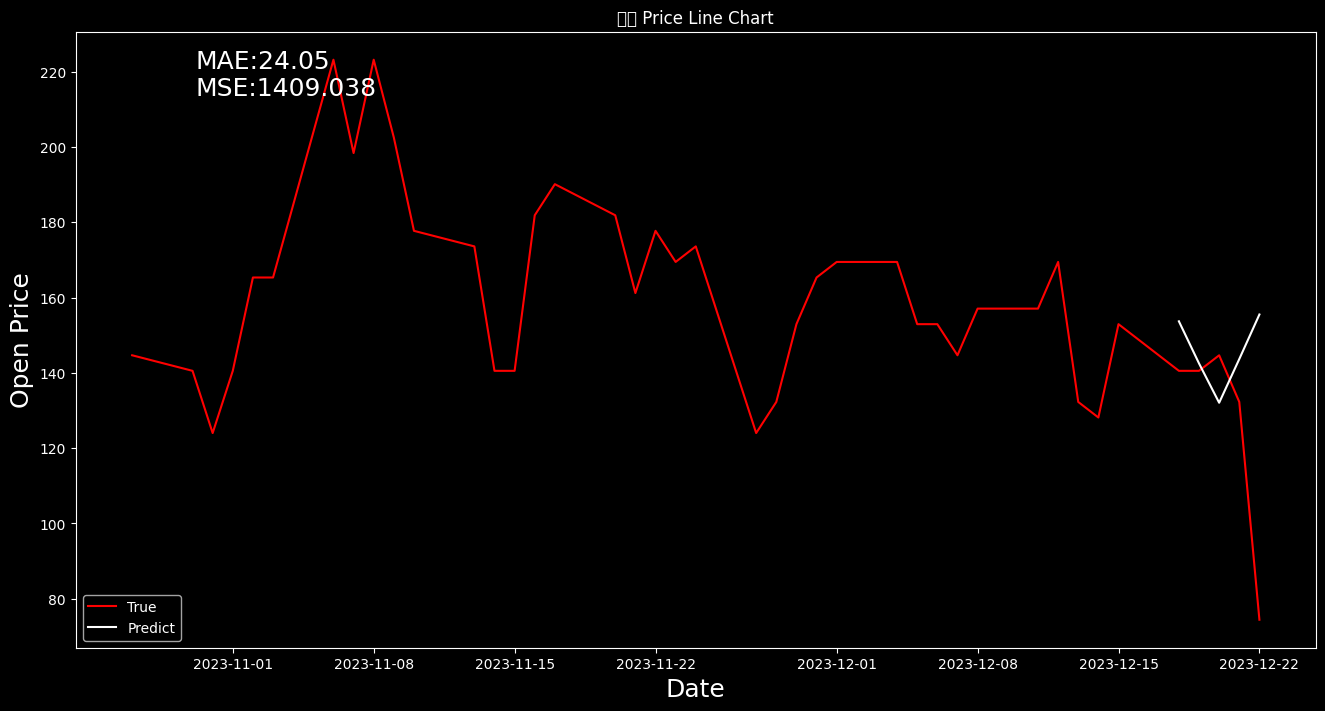

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23500 (\N{CJK UNIFIED IDEOGRAPH-5BCC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


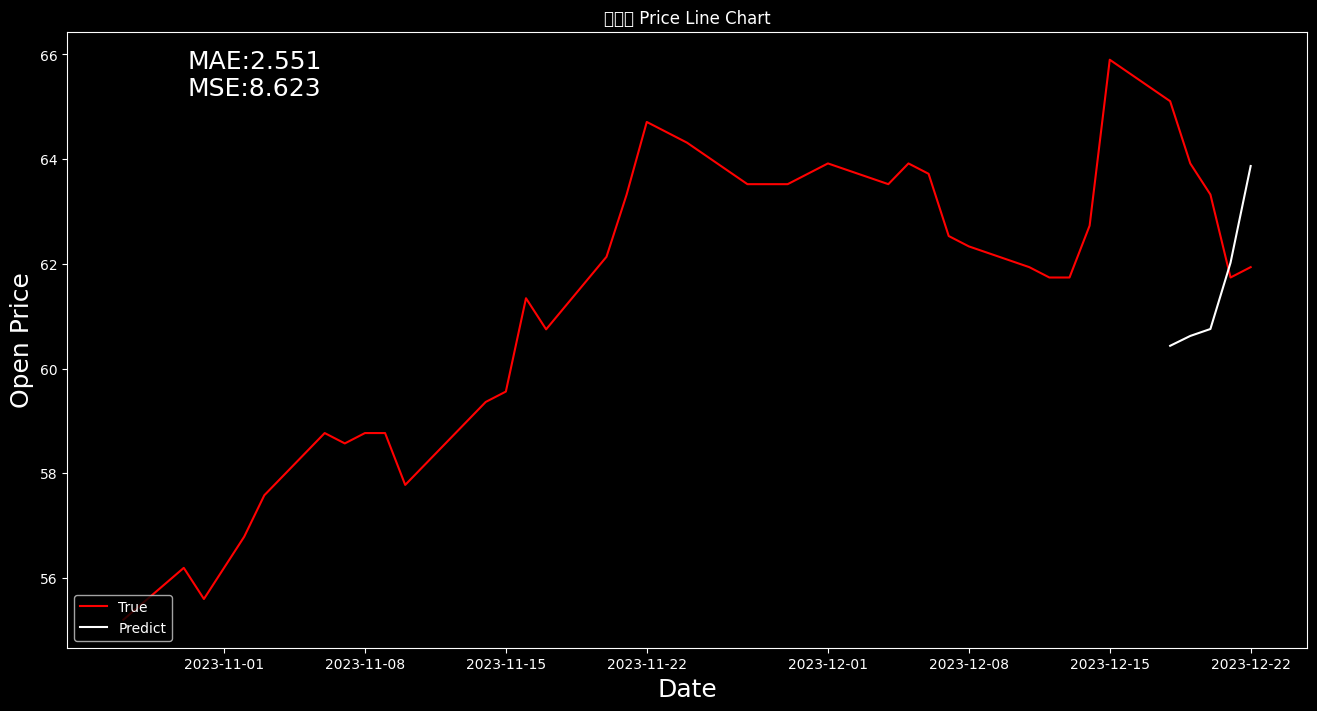

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


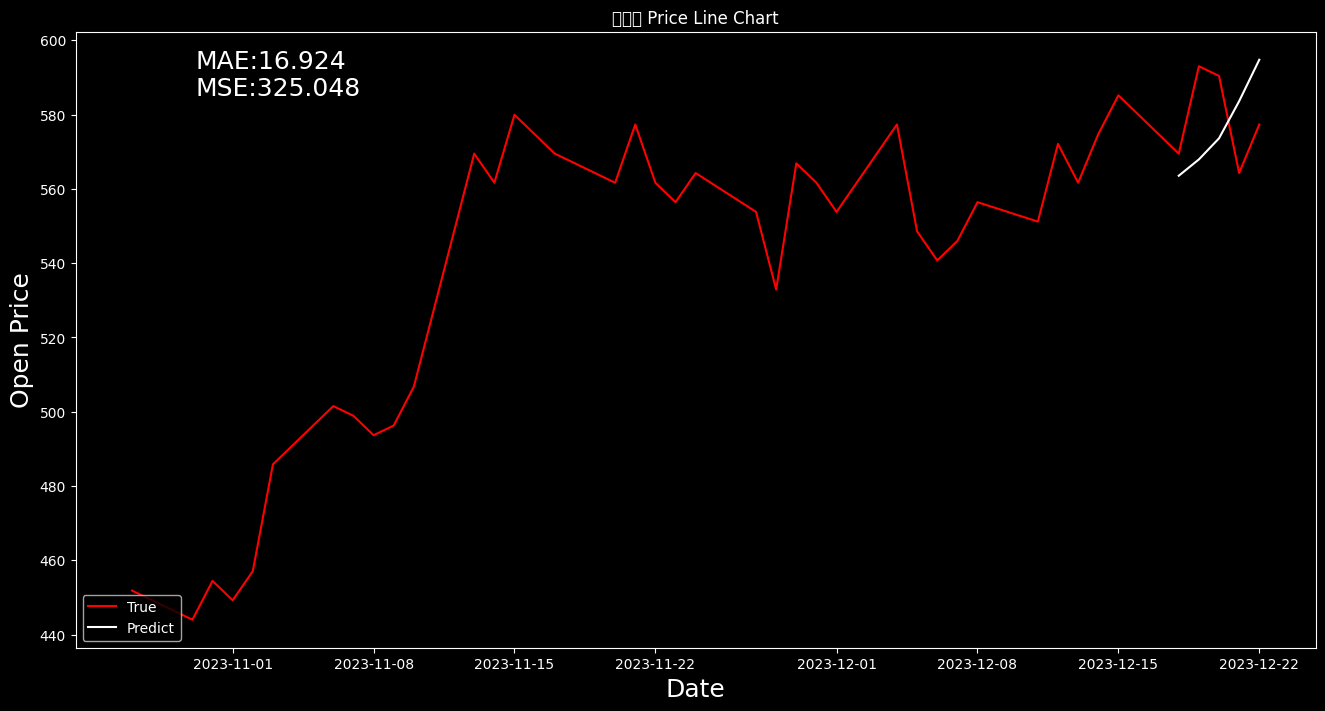

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


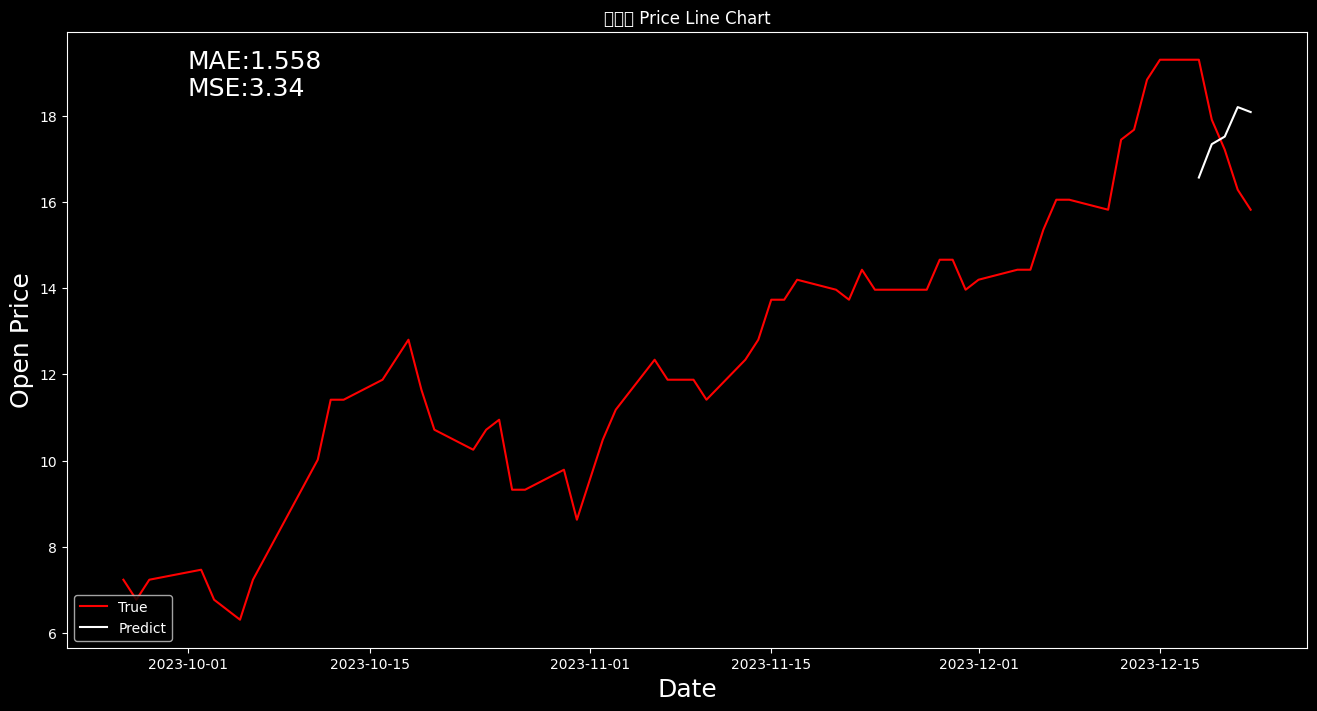

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


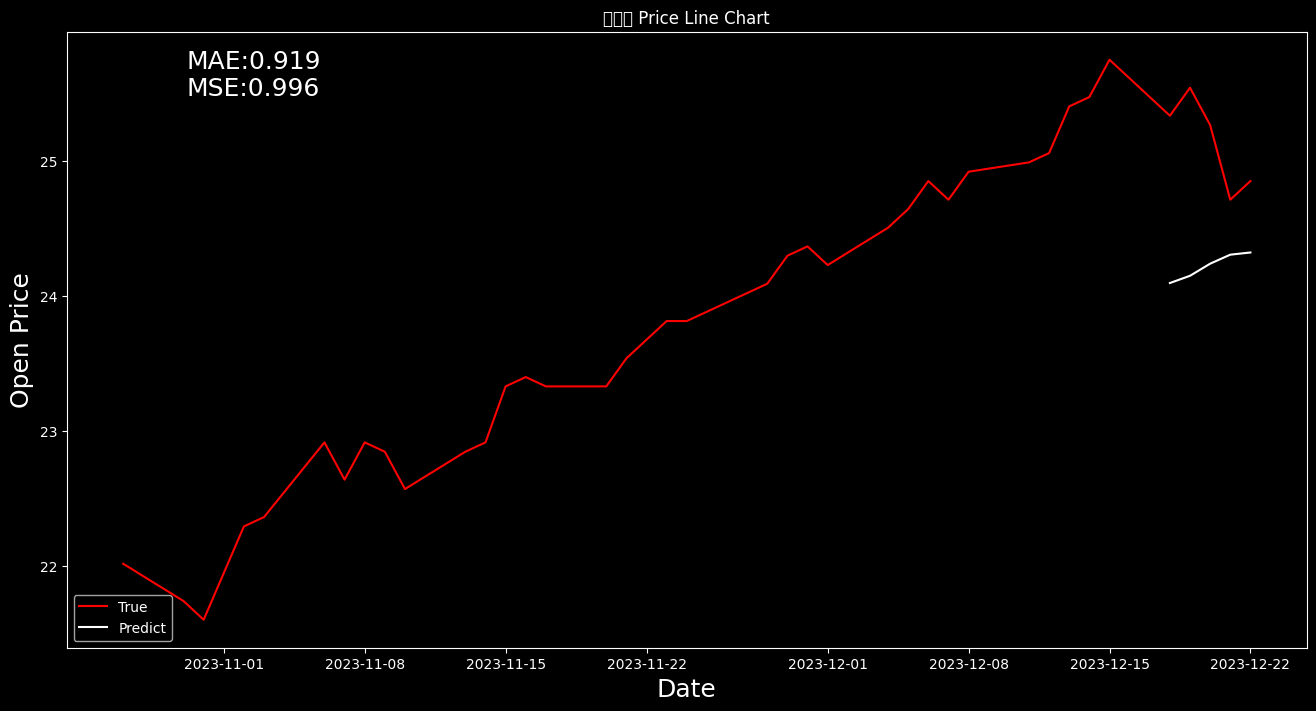

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22609 (\N{CJK UNIFIED IDEOGRAPH-5851}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


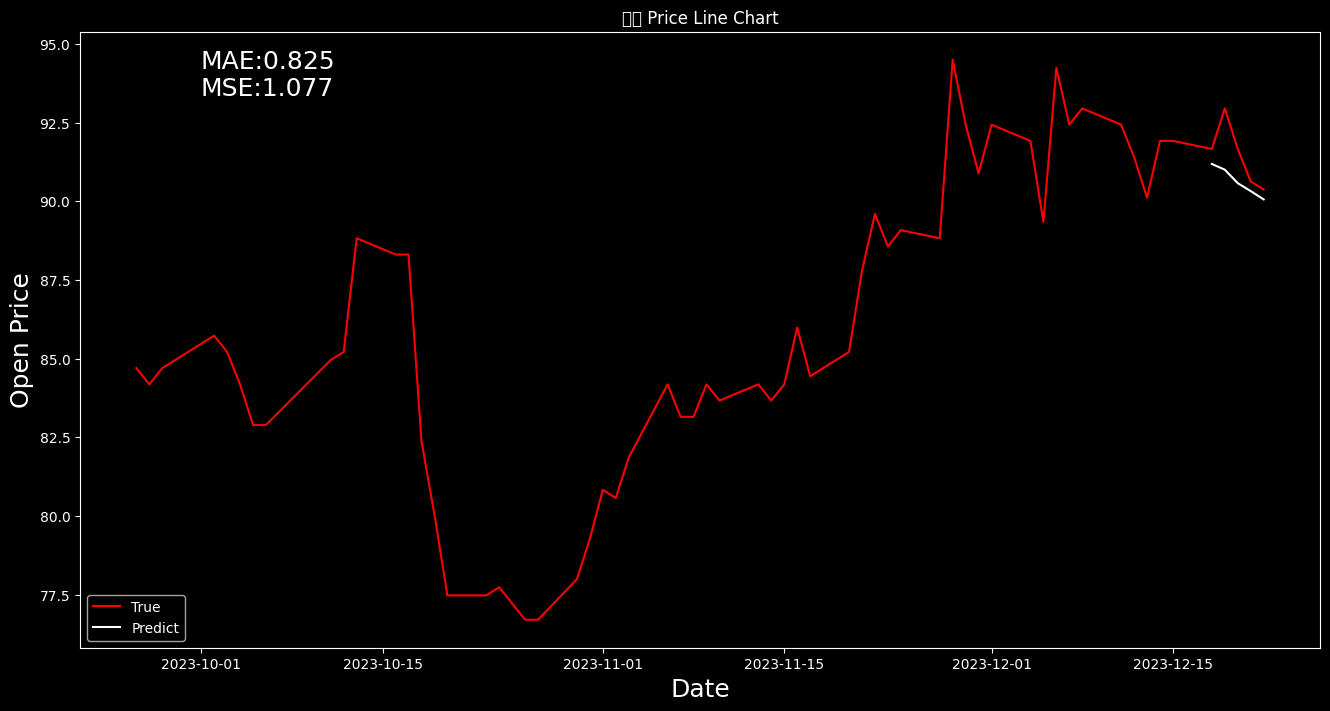

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27427 (\N{CJK UNIFIED IDEOGRAPH-6B23}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33288 (\N{CJK UNIFIED IDEOGRAPH-8208}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


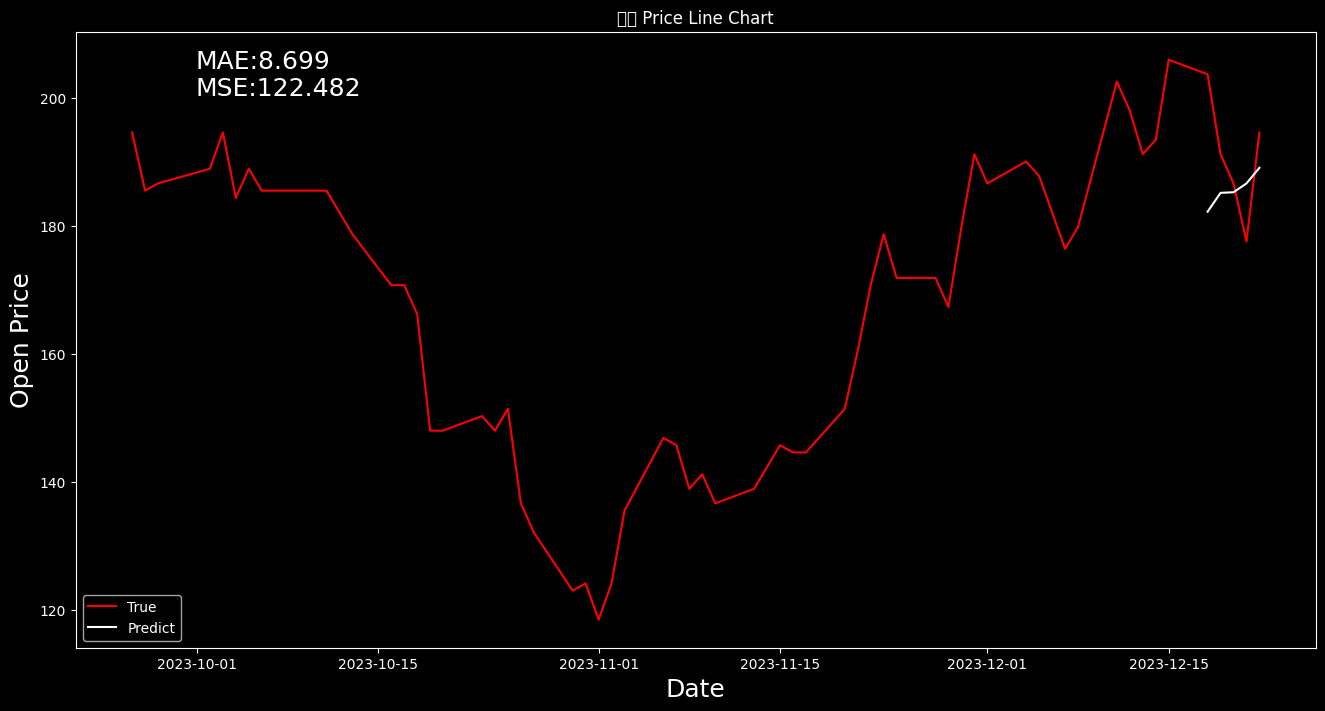

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38283 (\N{CJK UNIFIED IDEOGRAPH-958B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


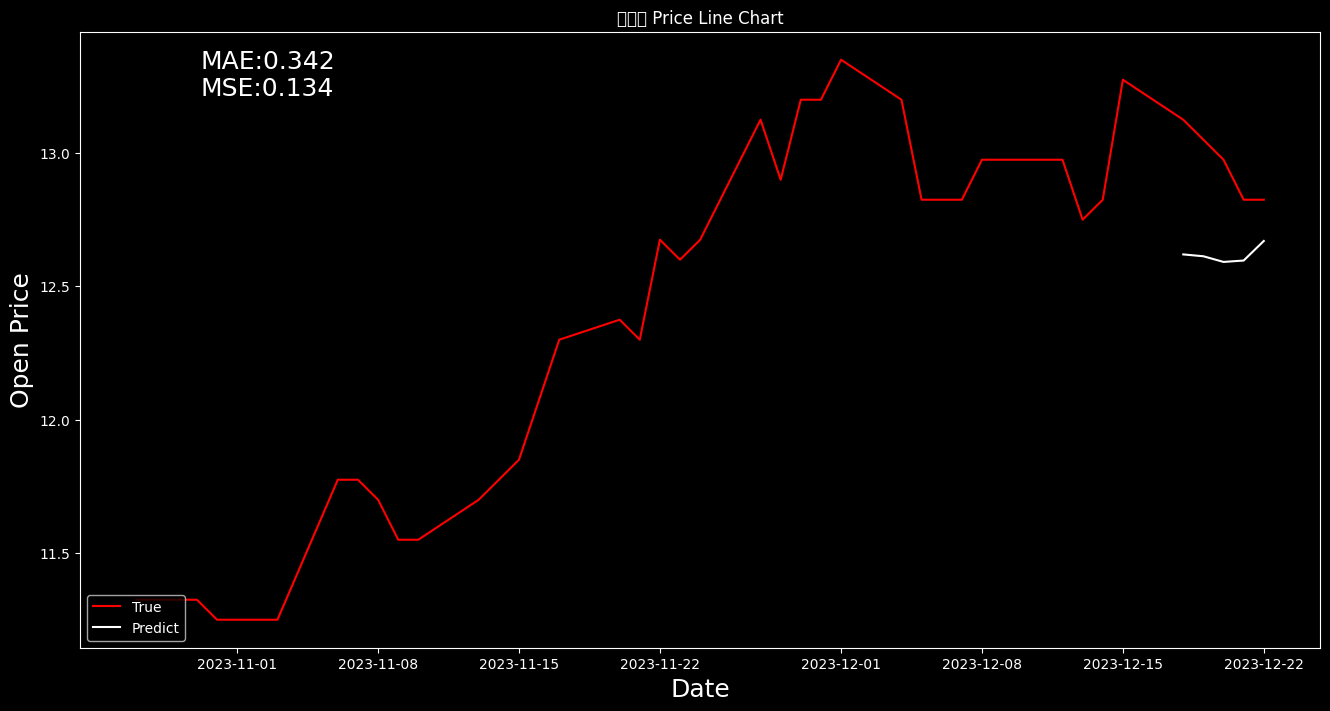

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36554 (\N{CJK UNIFIED IDEOGRAPH-8ECA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


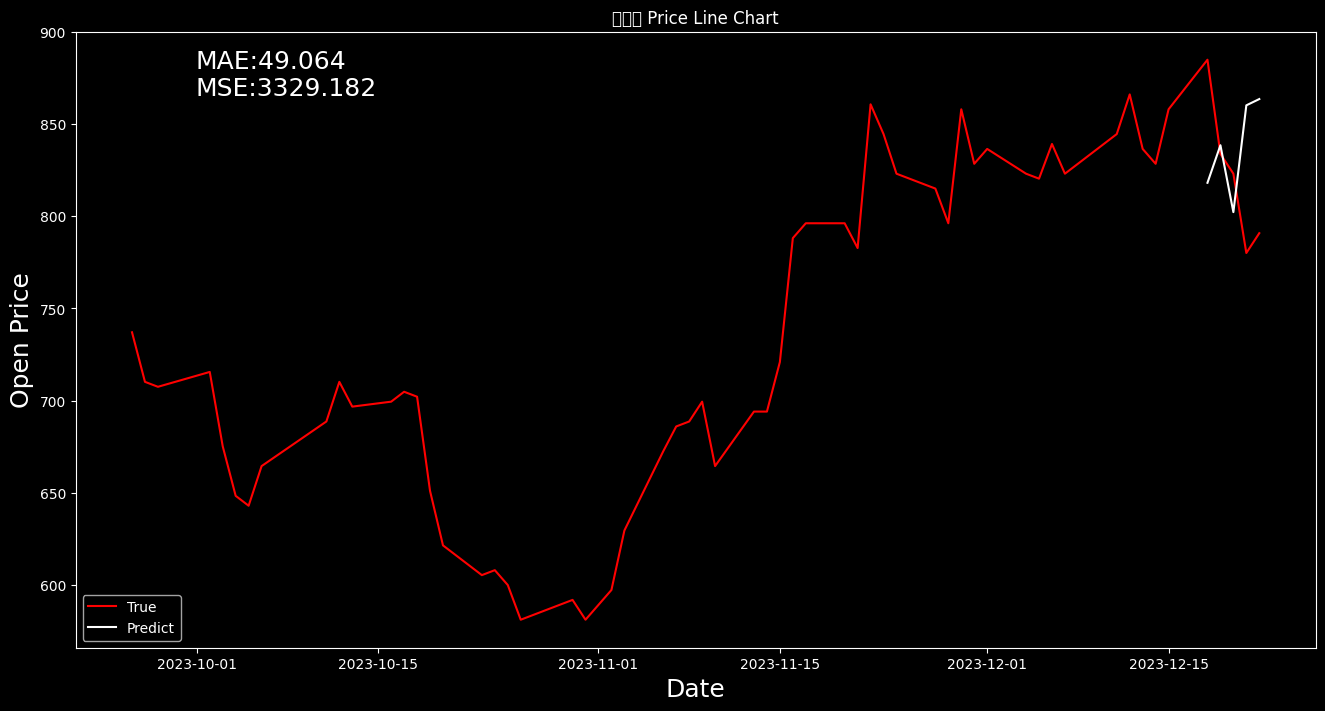

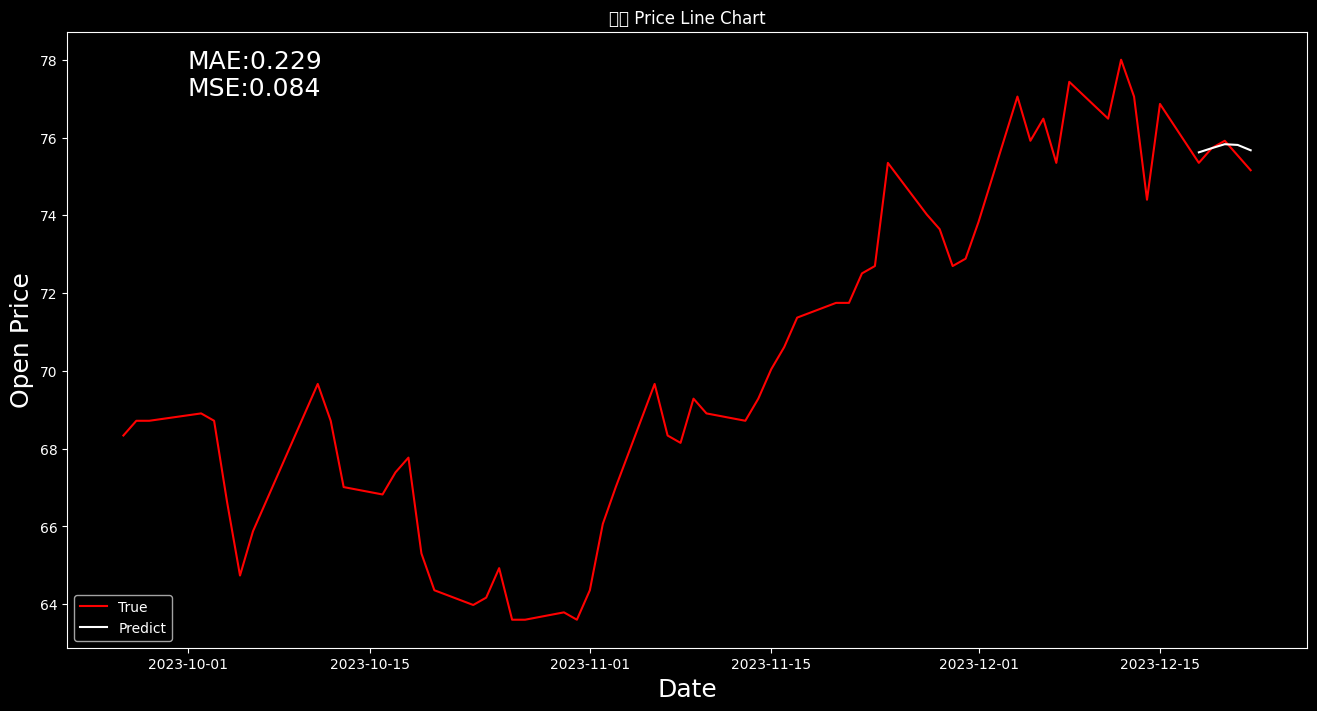

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27054 (\N{CJK UNIFIED IDEOGRAPH-69AE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


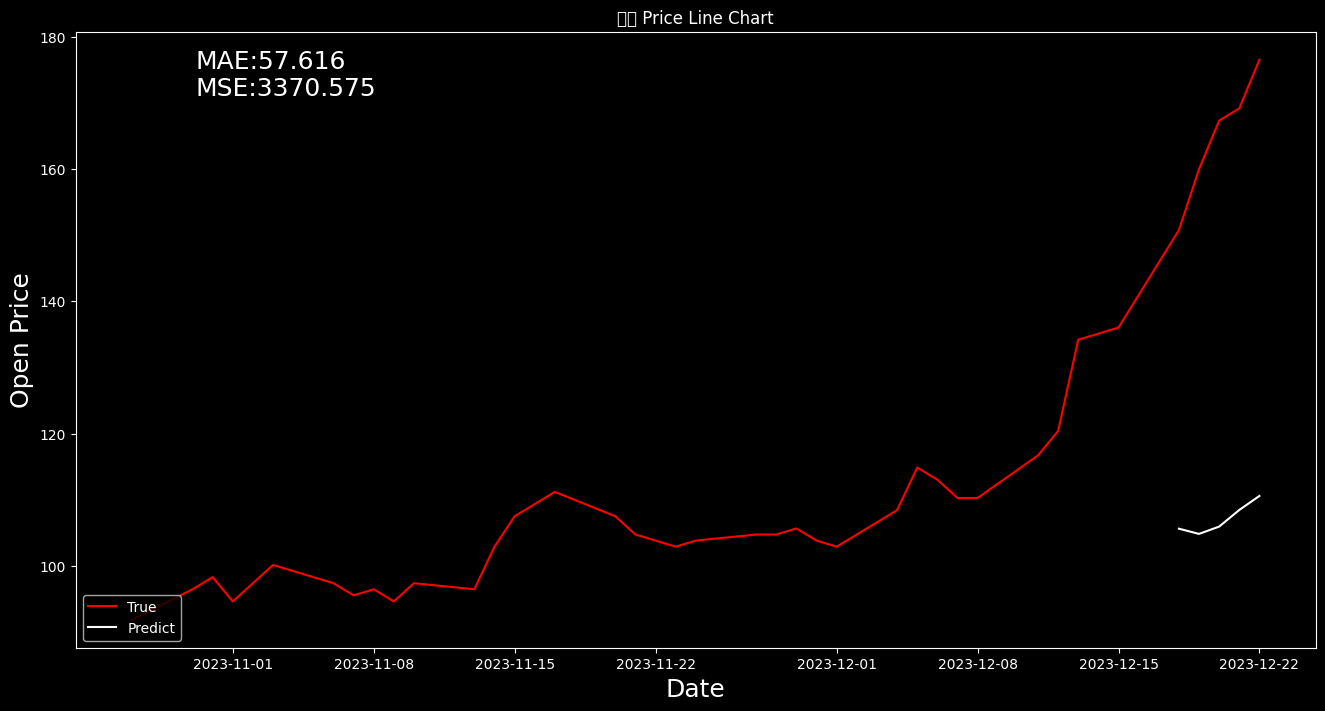

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31310 (\N{CJK UNIFIED IDEOGRAPH-7A4E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


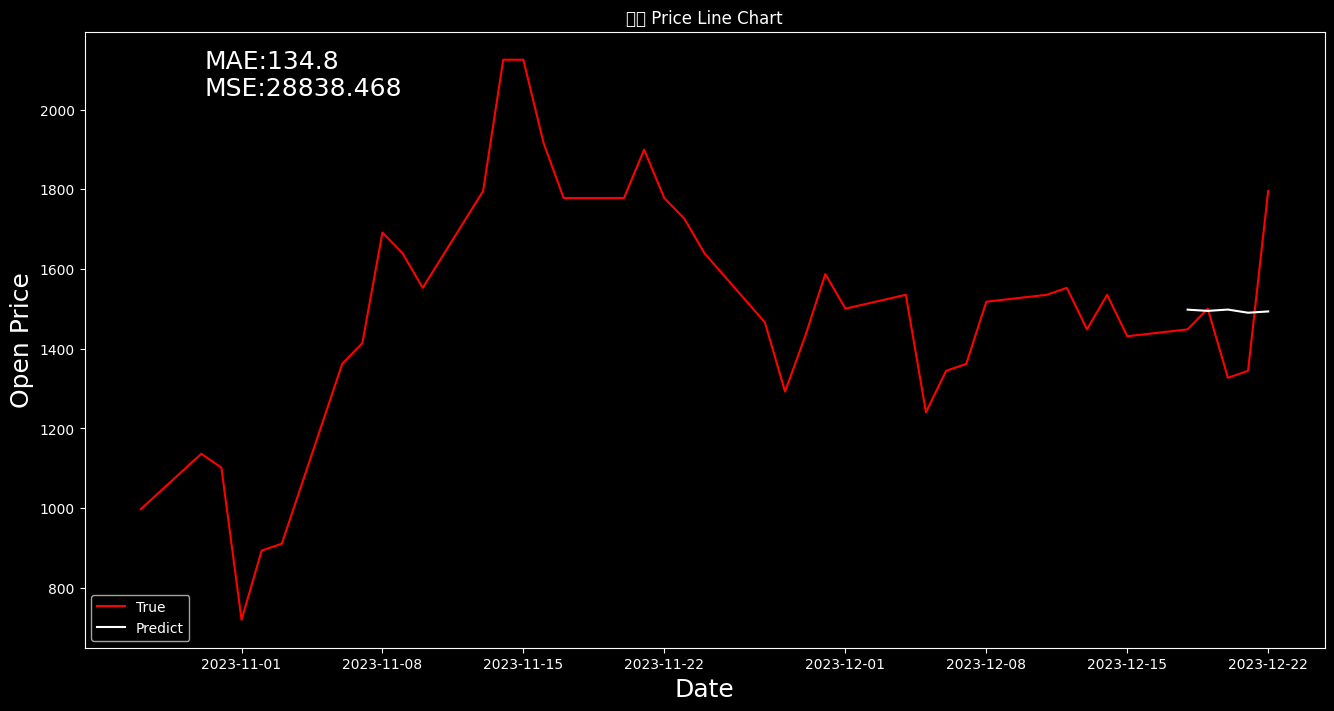

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24291 (\N{CJK UNIFIED IDEOGRAPH-5EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36948 (\N{CJK UNIFIED IDEOGRAPH-9054}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


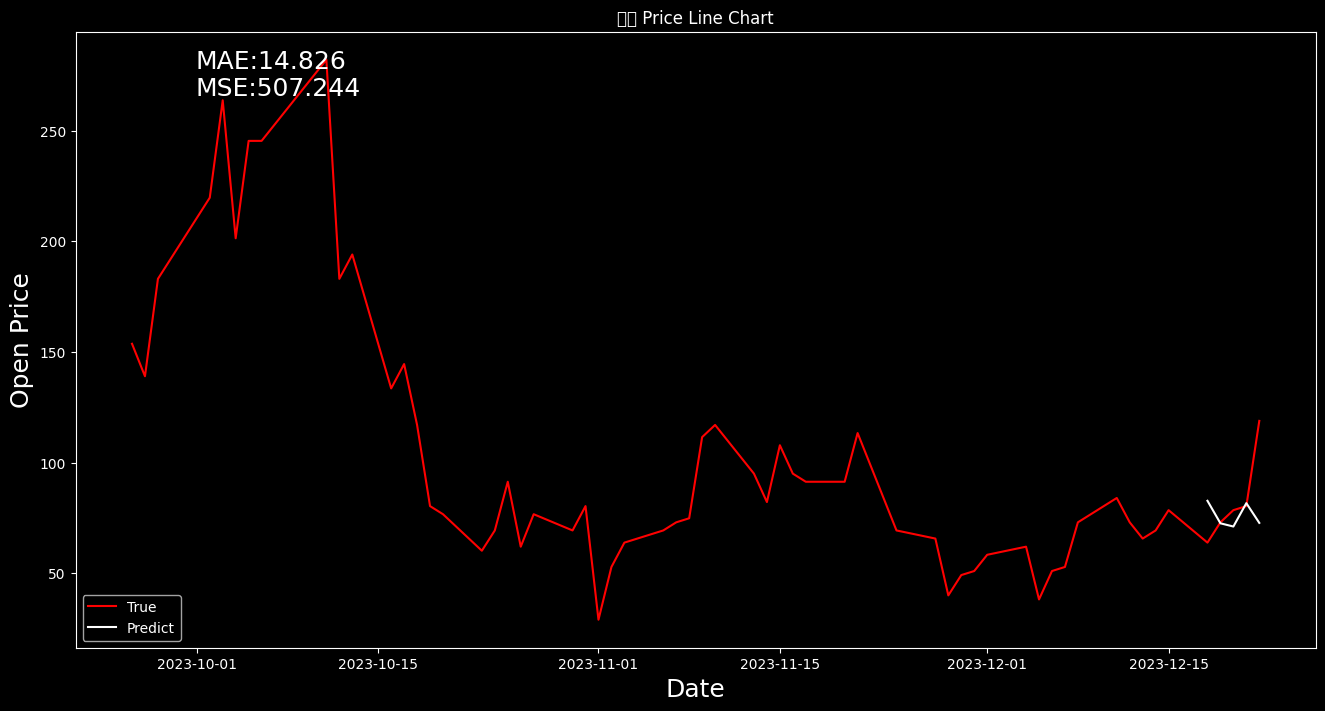

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37504 (\N{CJK UNIFIED IDEOGRAPH-9280}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


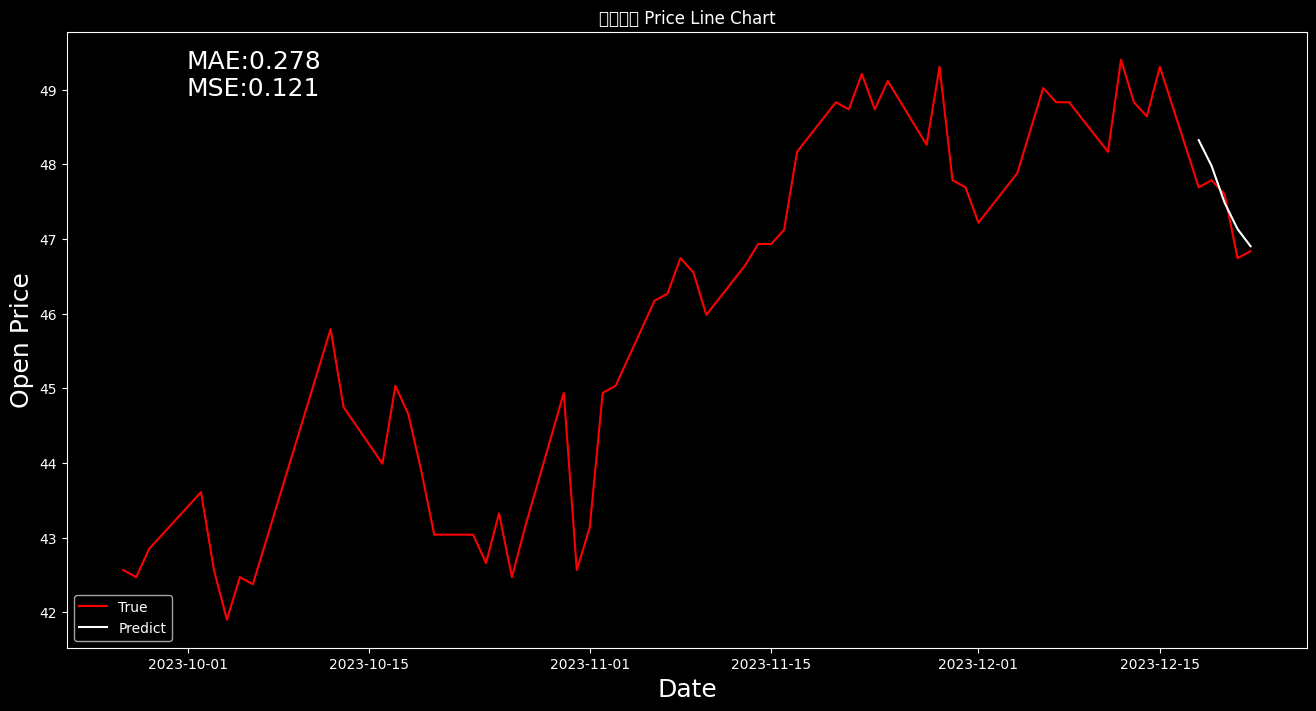

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


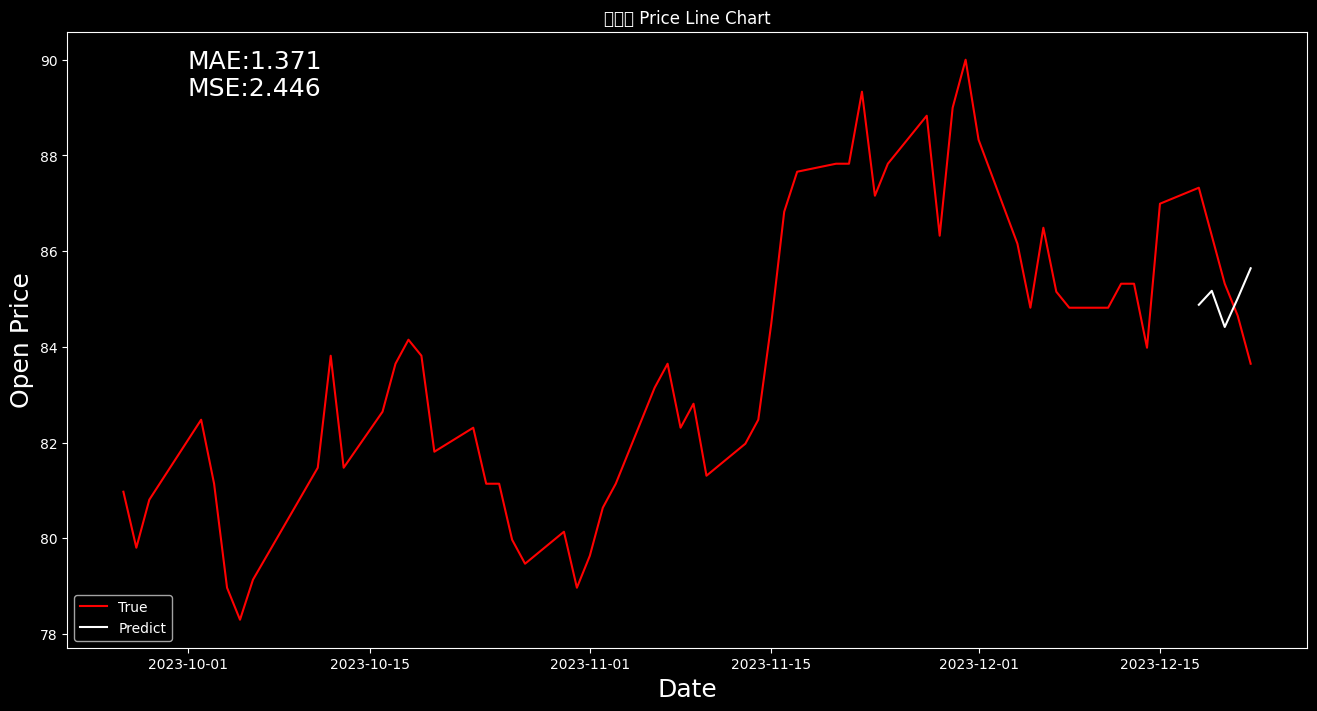

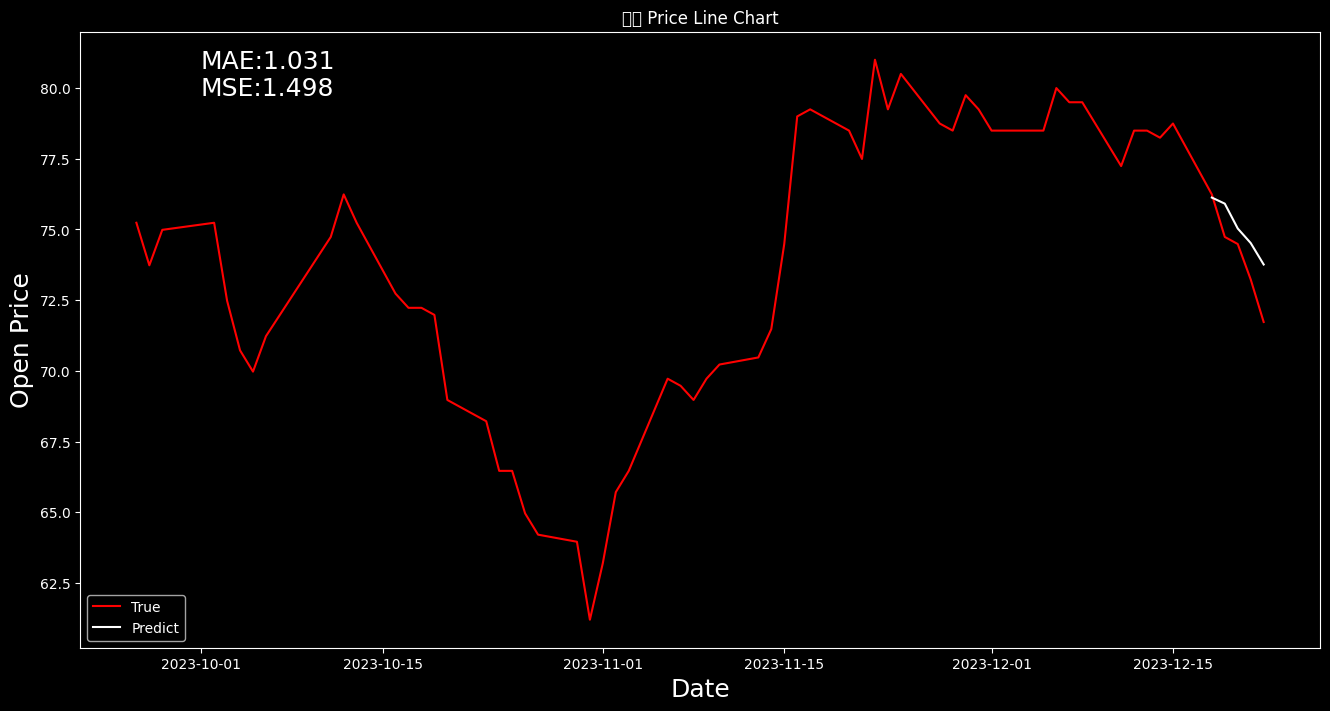

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24040 (\N{CJK UNIFIED IDEOGRAPH-5DE8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


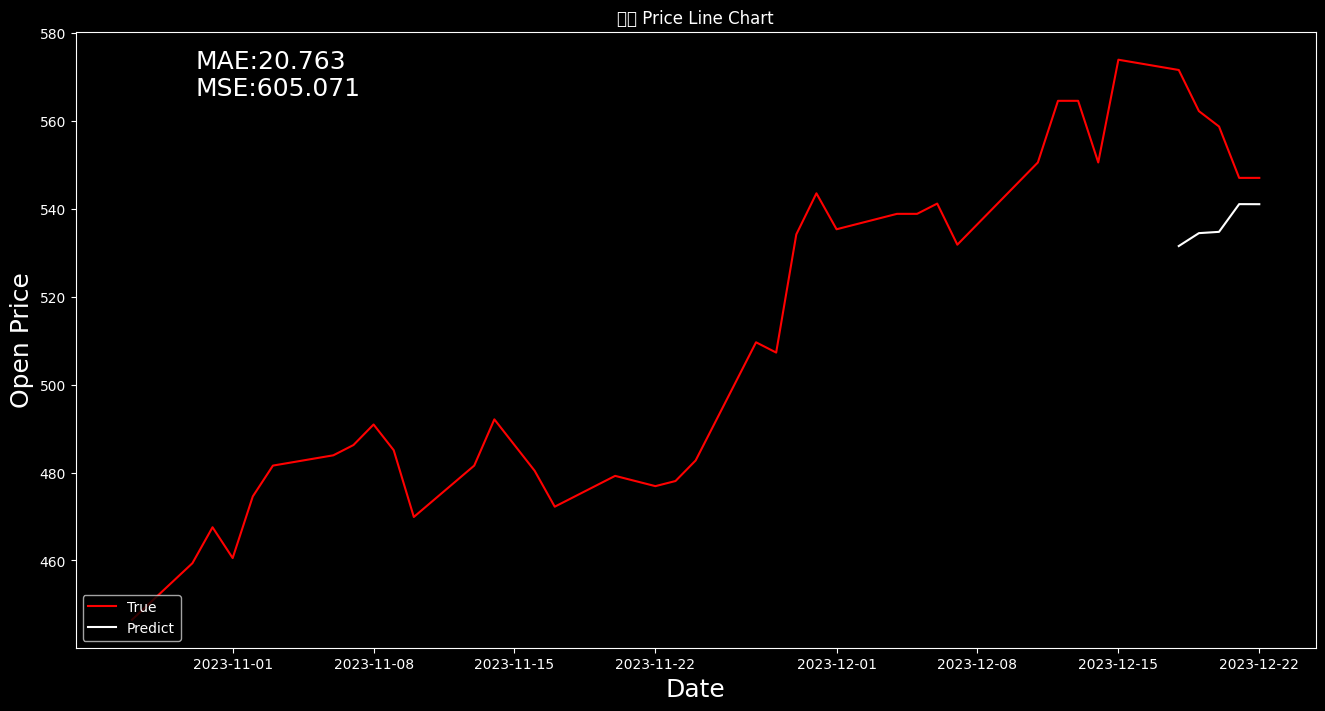

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31199 (\N{CJK UNIFIED IDEOGRAPH-79DF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


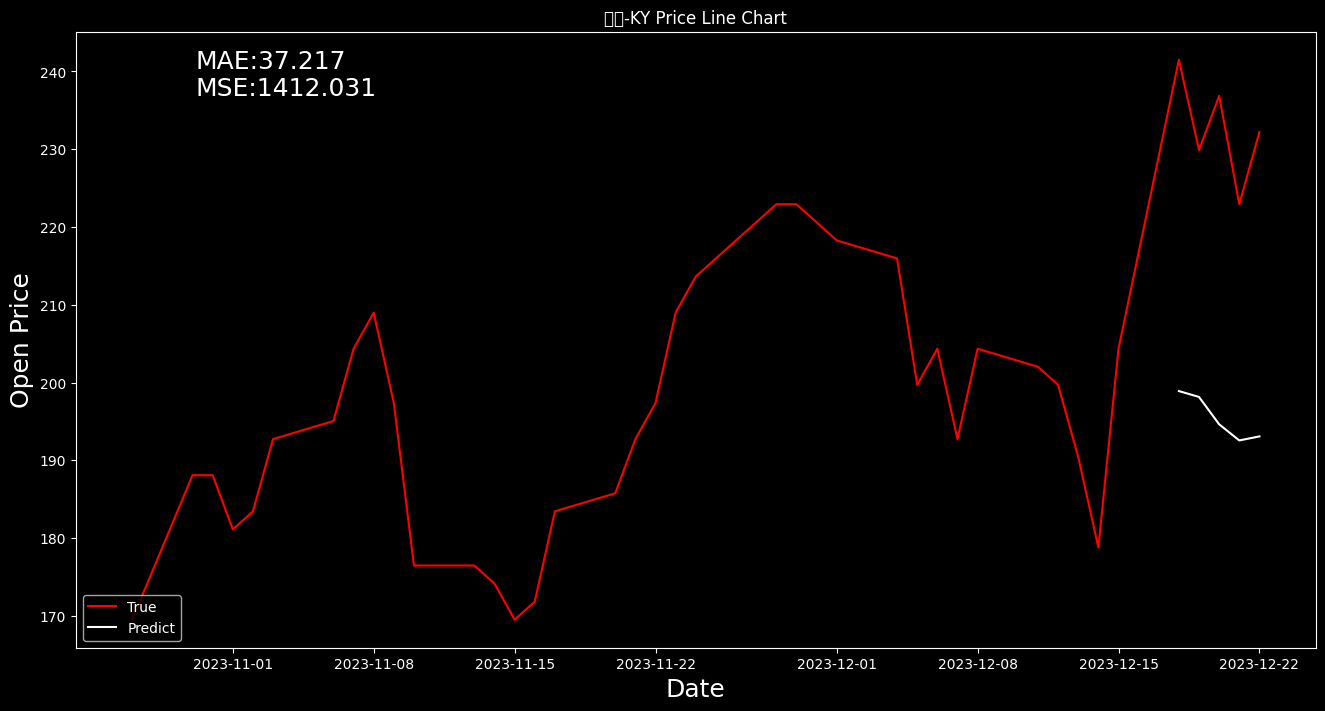

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33775 (\N{CJK UNIFIED IDEOGRAPH-83EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


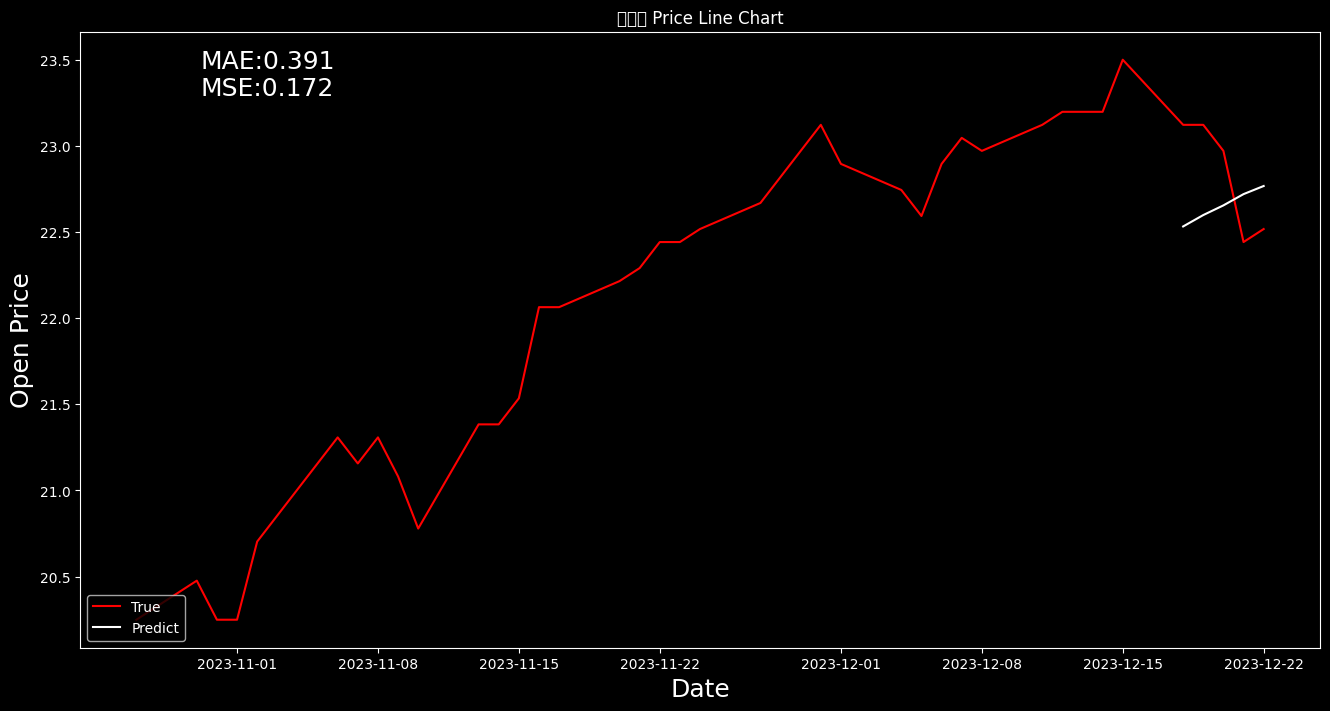

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24432 (\N{CJK UNIFIED IDEOGRAPH-5F70}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


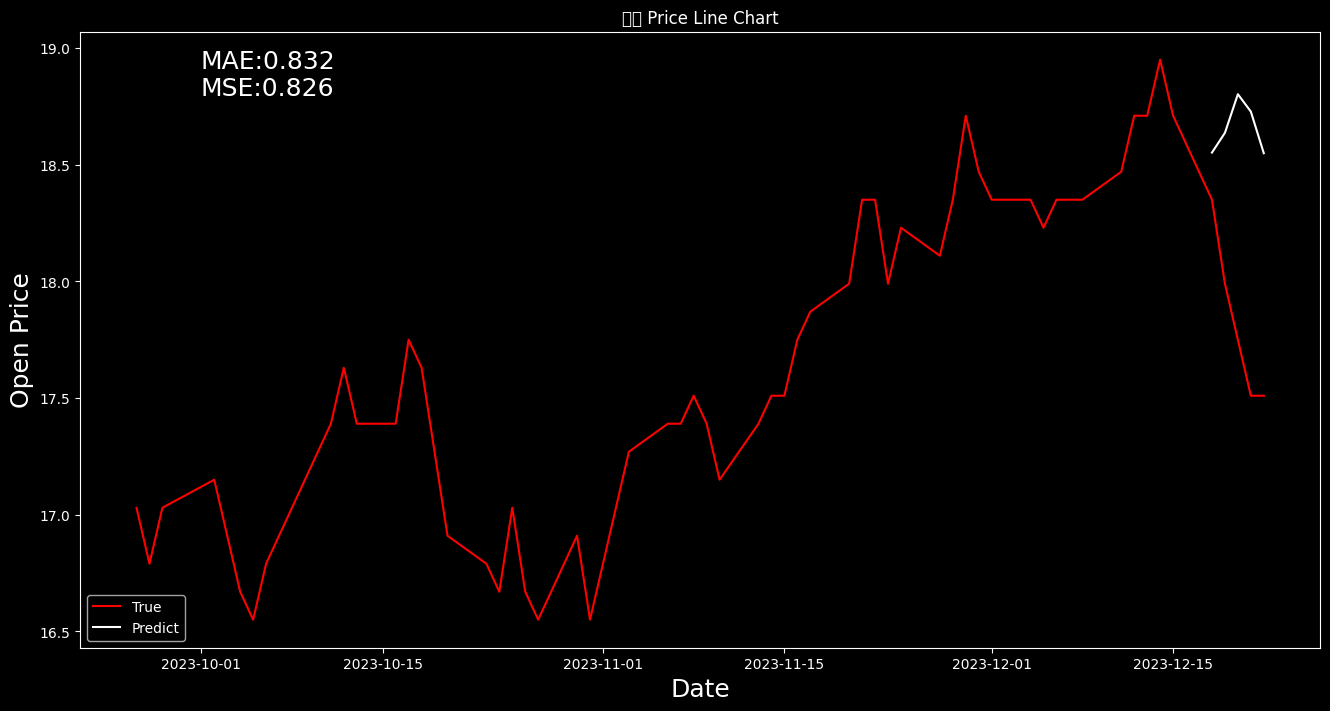

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


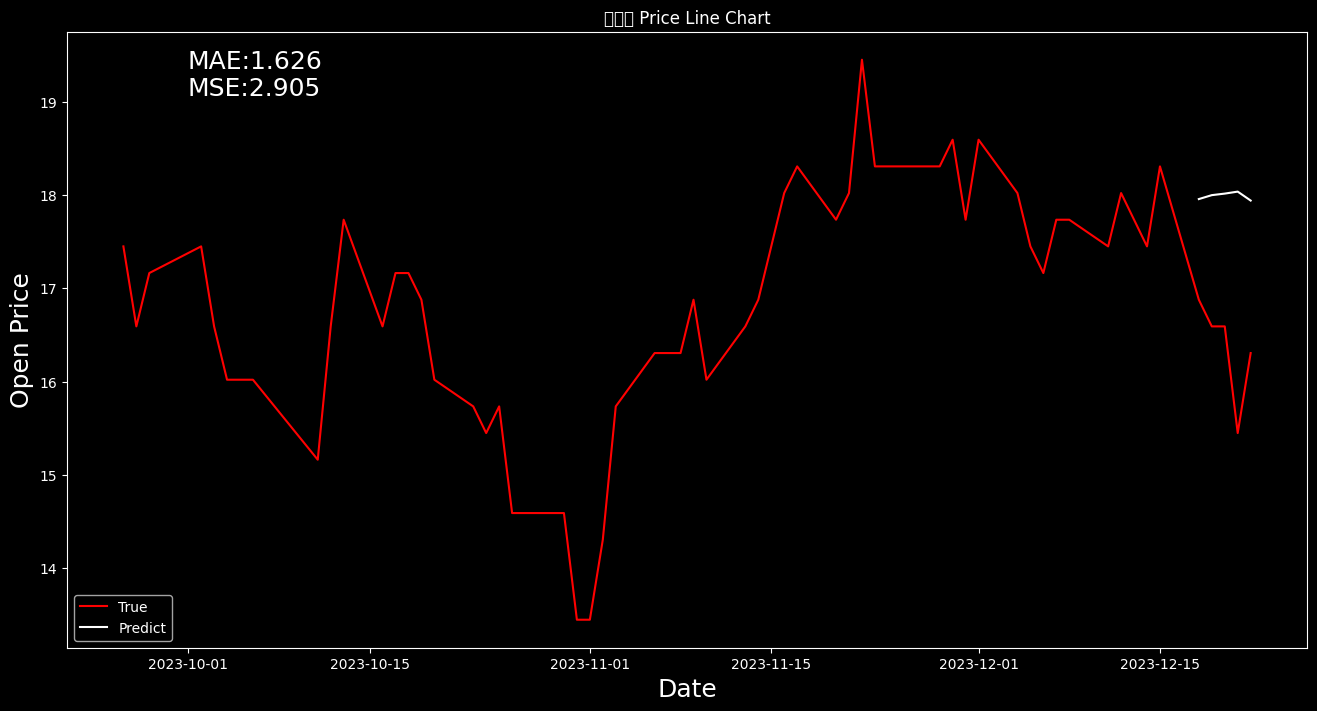

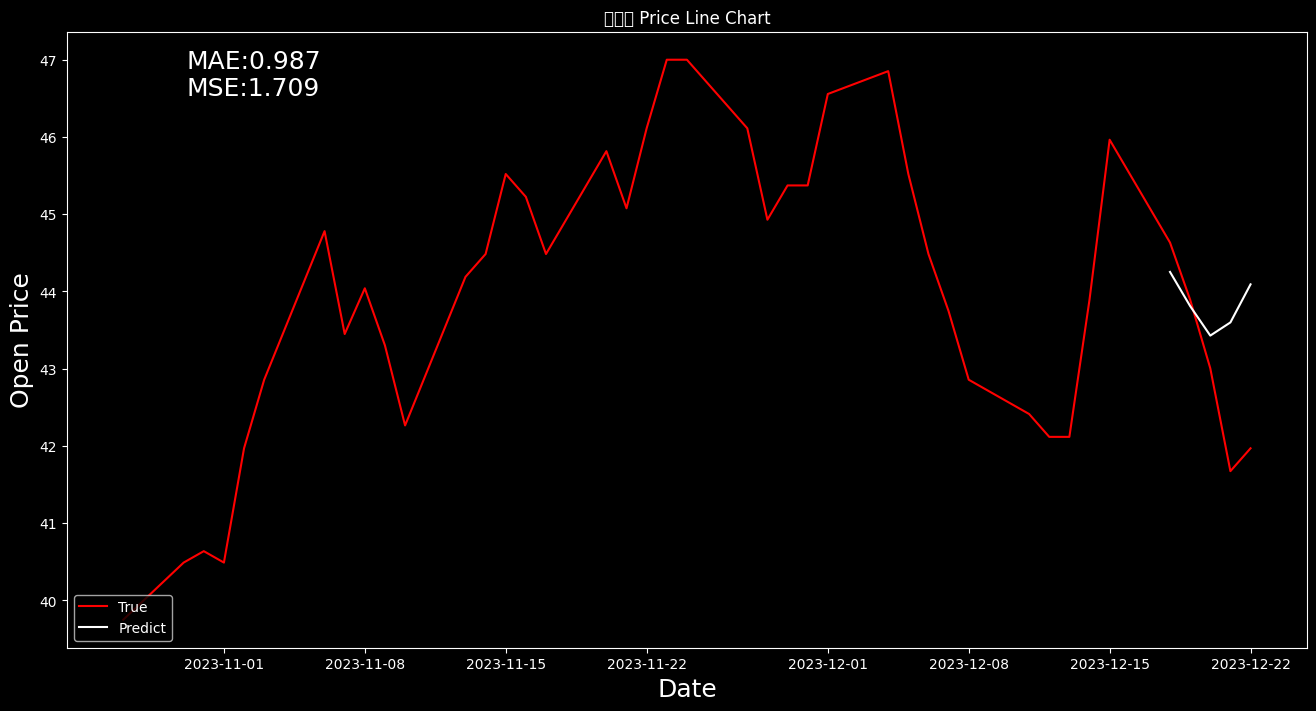

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30740 (\N{CJK UNIFIED IDEOGRAPH-7814}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


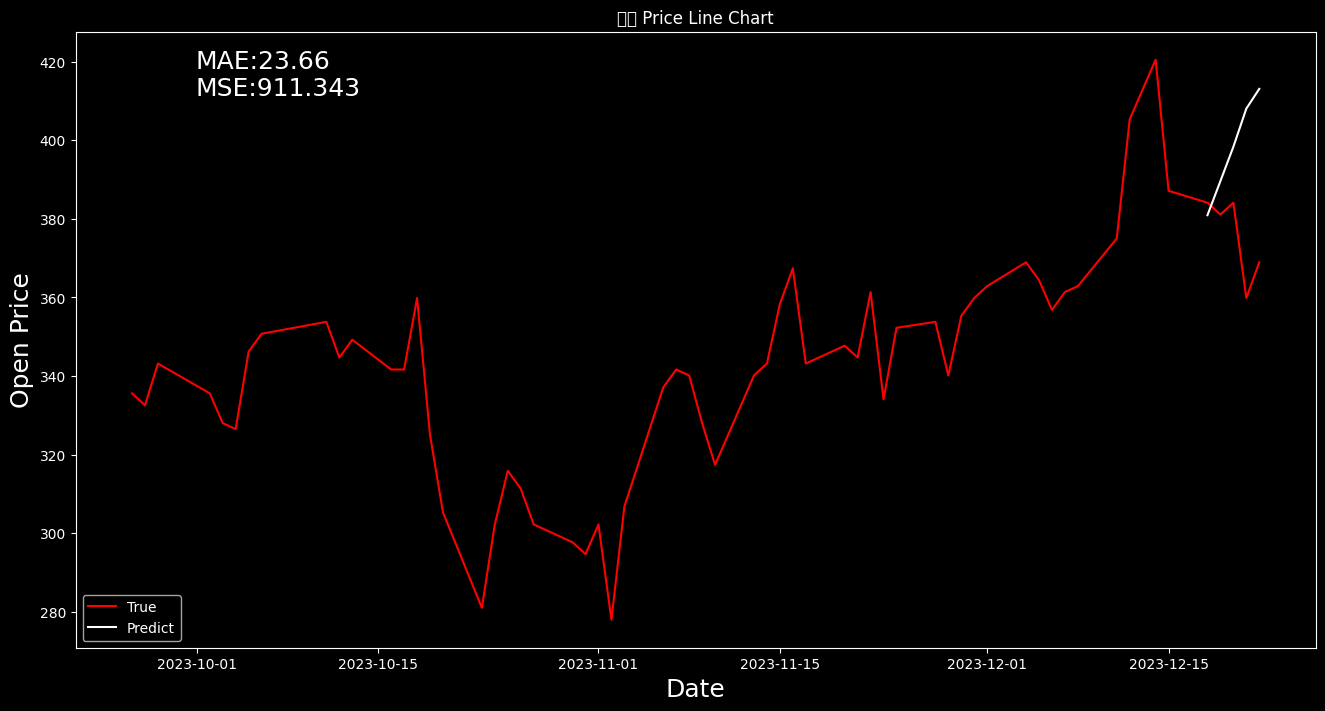

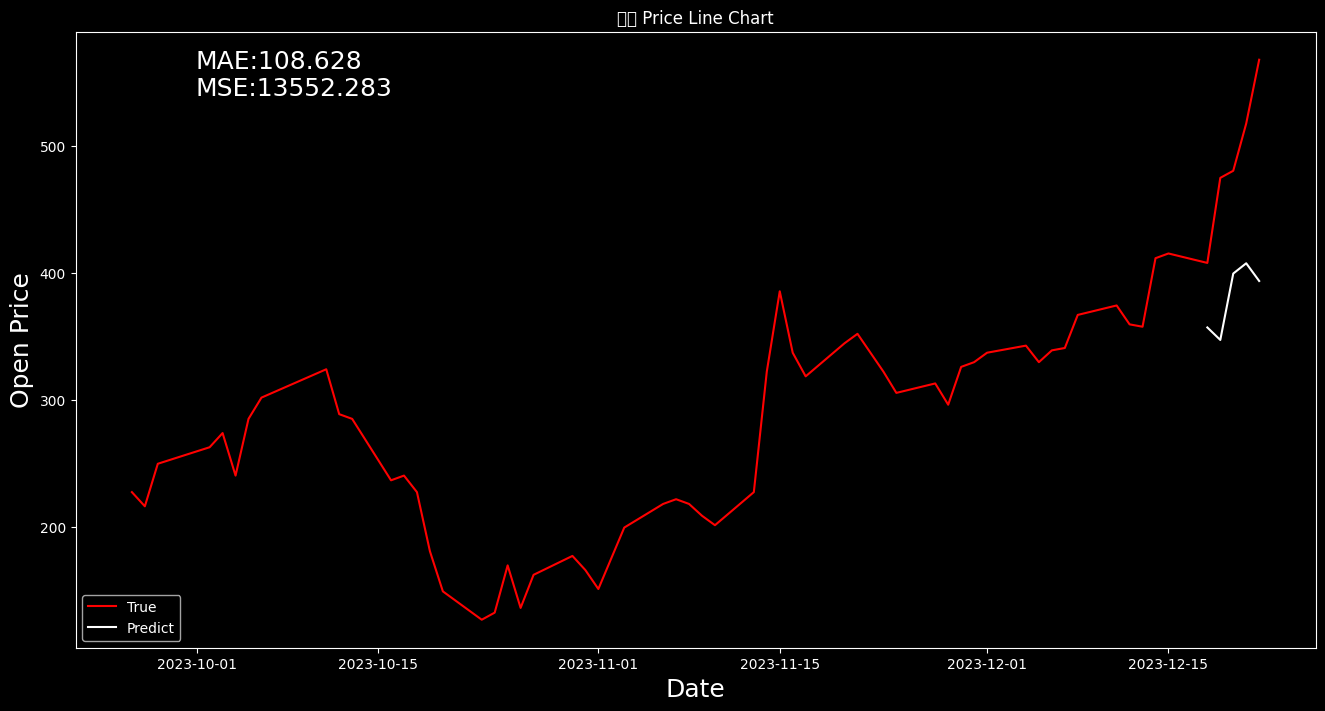

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35424 (\N{CJK UNIFIED IDEOGRAPH-8A60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


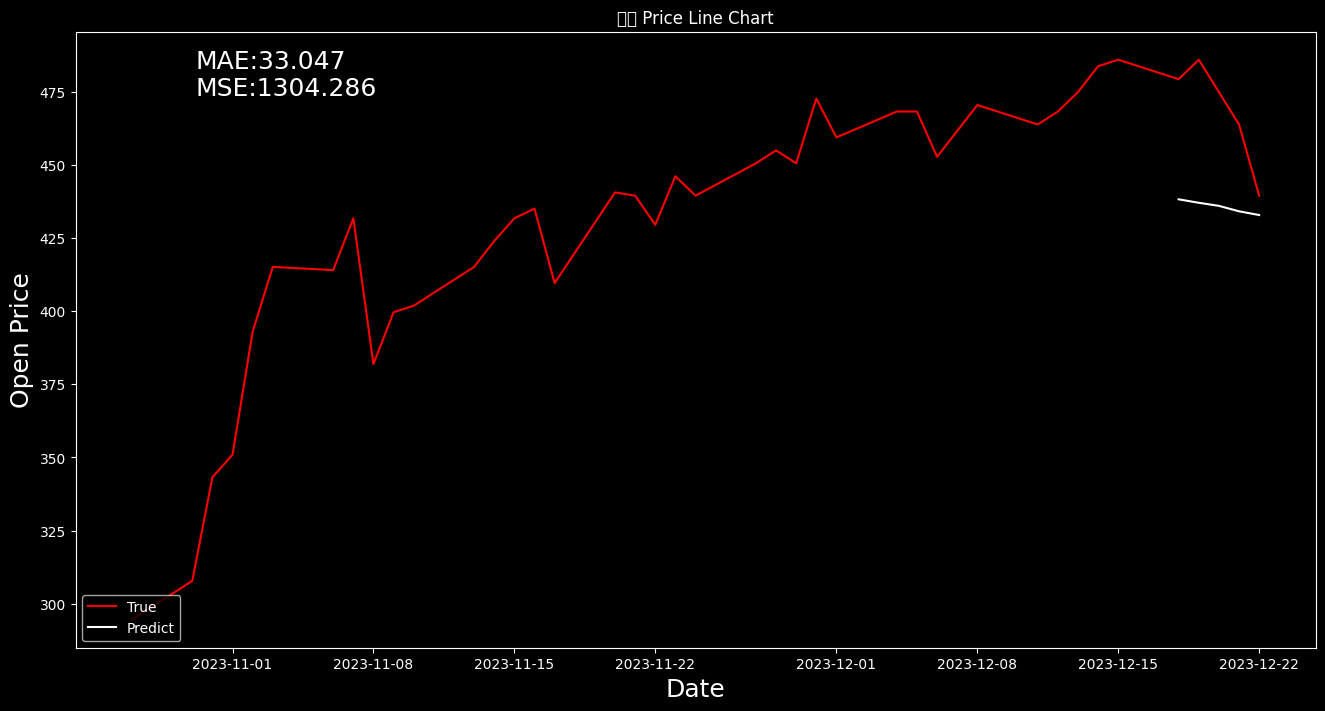

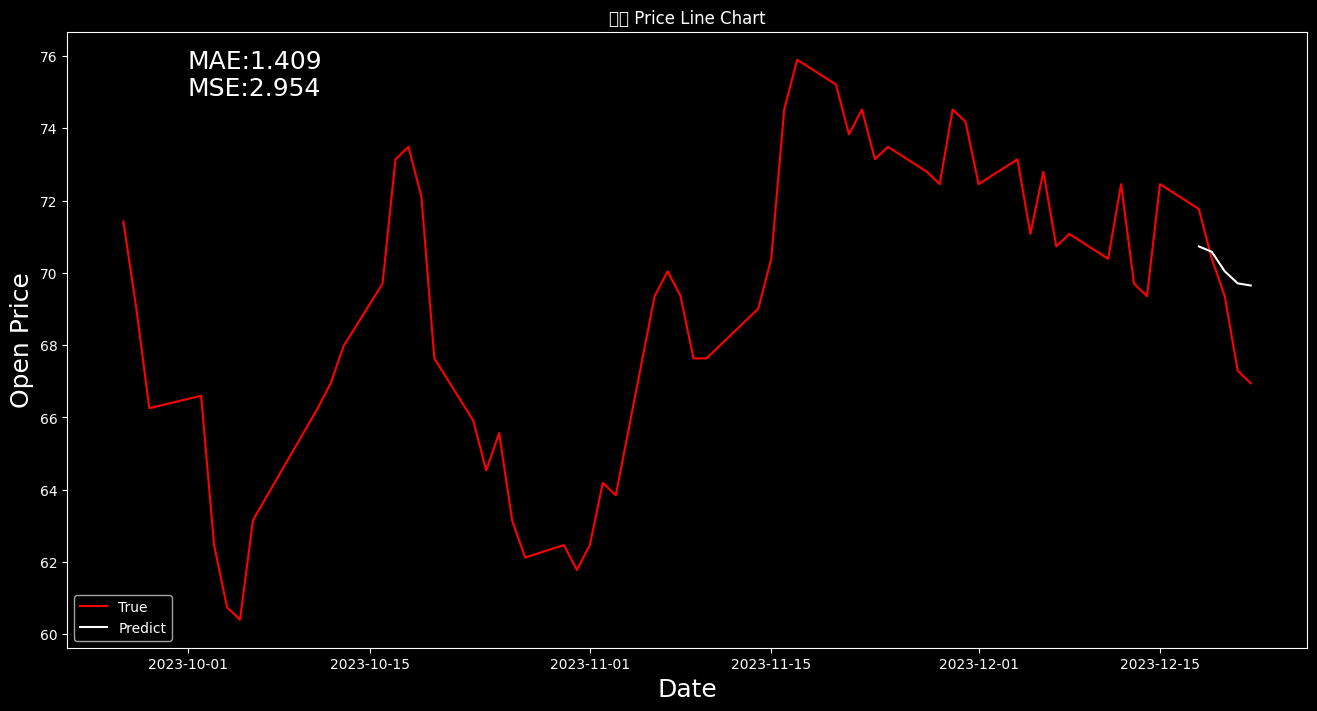

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28771 (\N{CJK UNIFIED IDEOGRAPH-7063}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


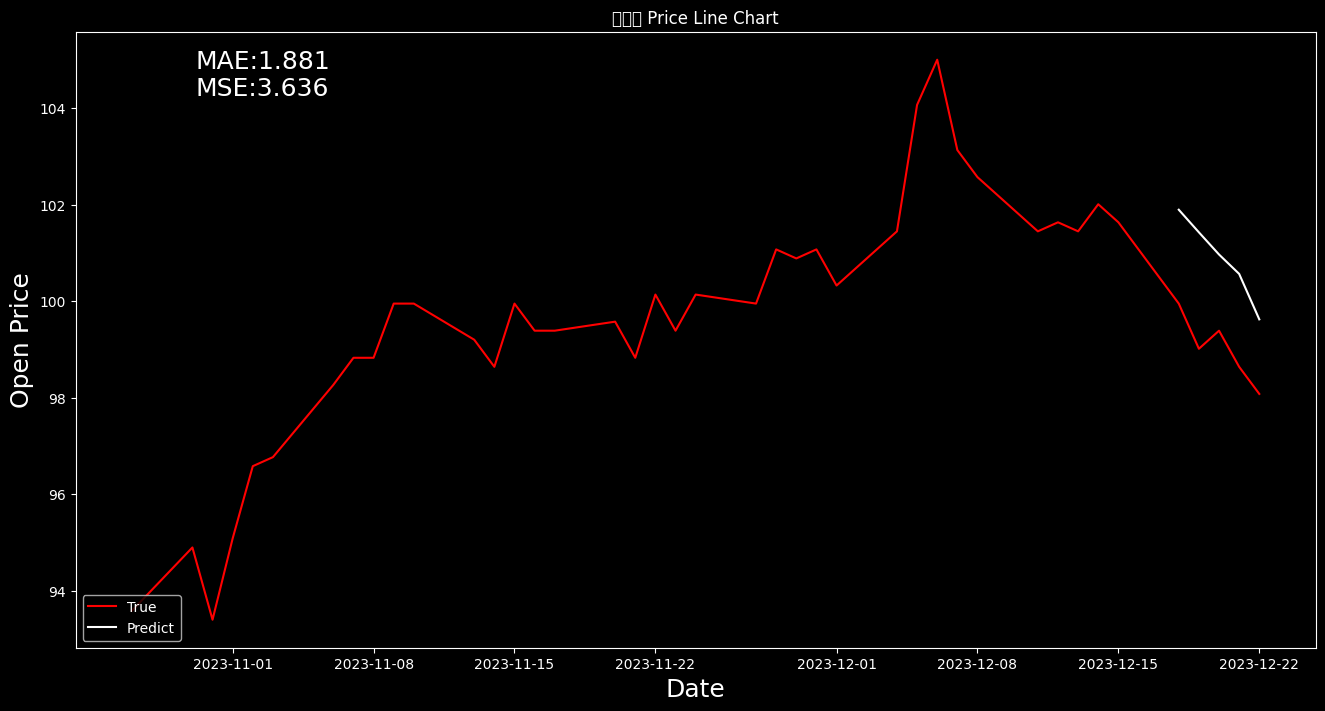

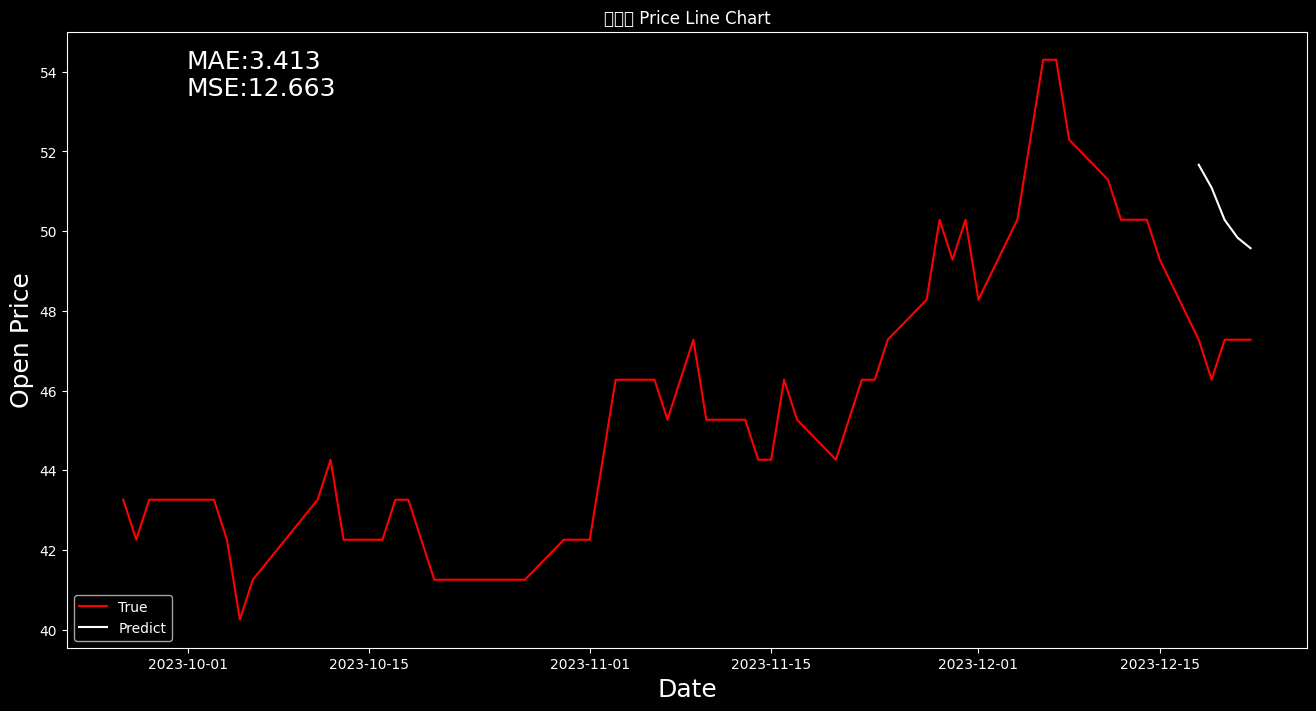

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23542 (\N{CJK UNIFIED IDEOGRAPH-5BF6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


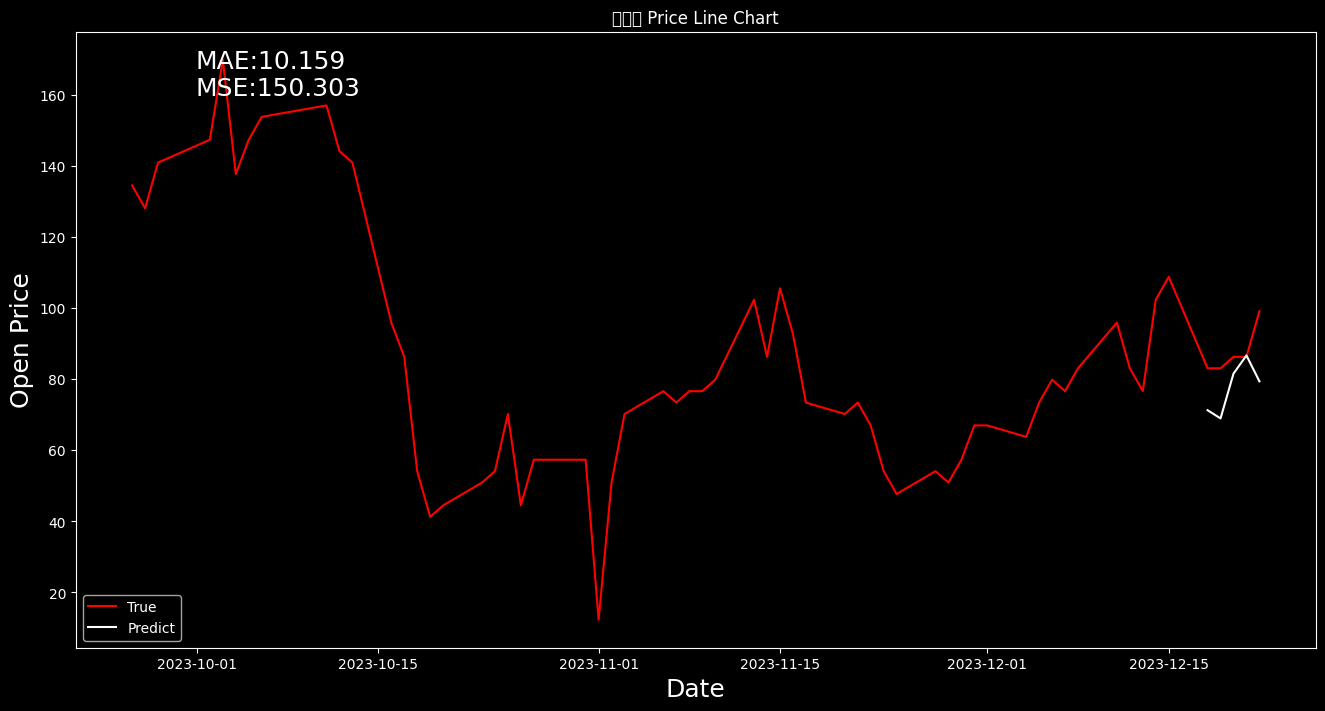

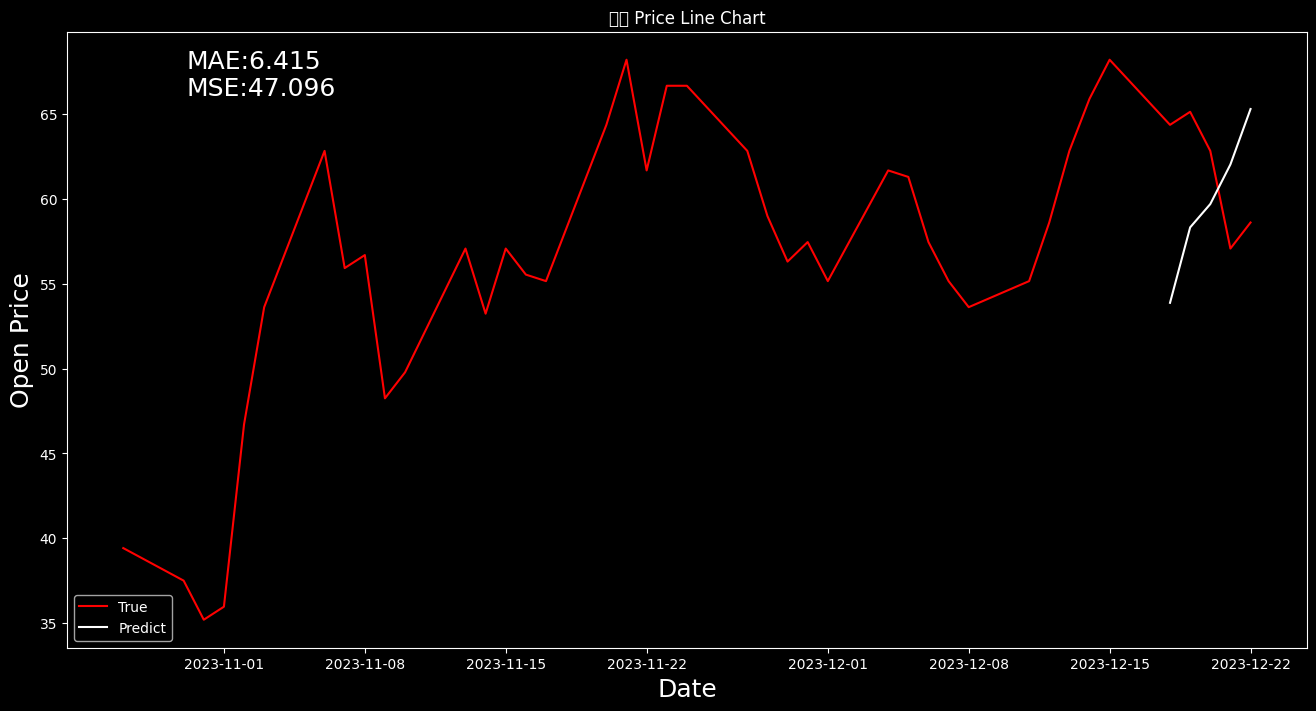

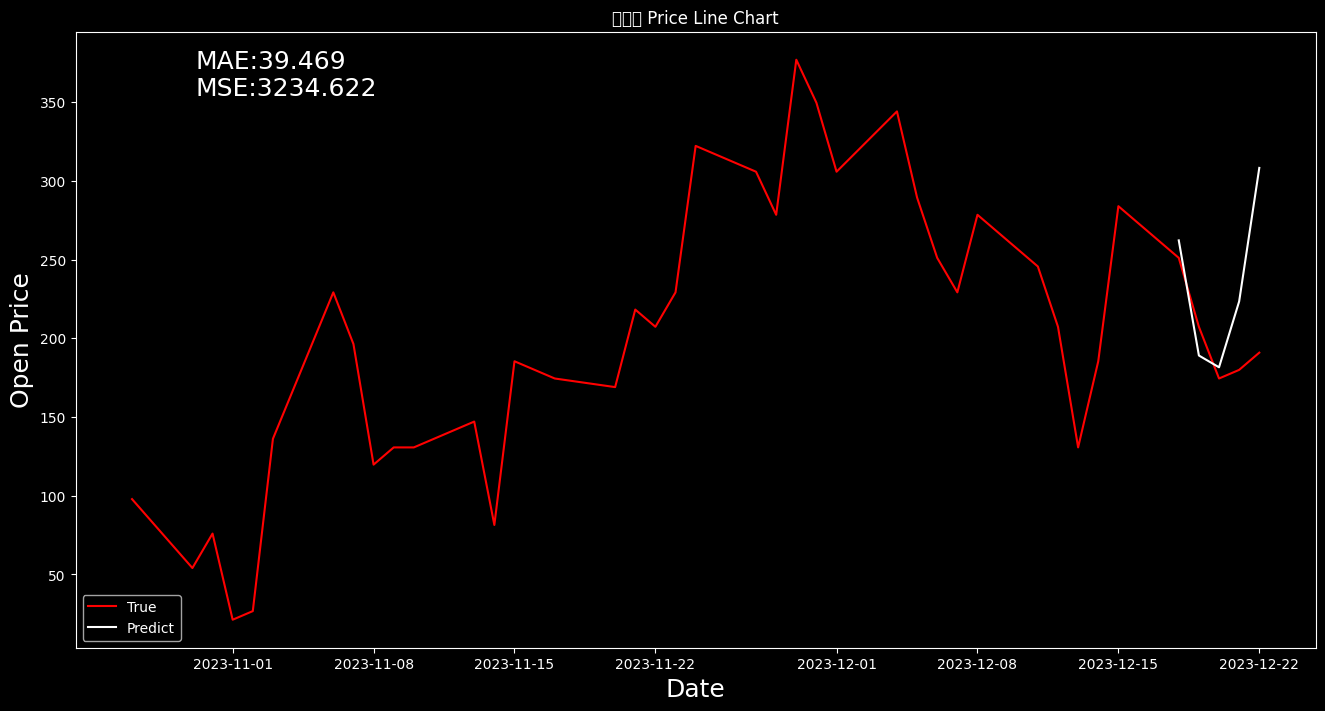

In [90]:
for company, df_comp in tqdm(company_df_dict.items()):
  print('\n'+company+'\n')

  input_num = int(final_model.loc[final_model['company'] == company, 'input'])

  # load scaler and apply
  for col in df_comp.columns:
    if col == 'Date':
      continue
    scaler = joblib.load(home+params_dir+'/'+company+f'/scaler_{col}.z')
    df_comp[col] = scaler.fit_transform(df_comp.filter([col]).values)

  # load model and make prediction
  X_pred = Get_Dataset(df_comp, input_num)
  model = load_model(home+params_dir+'/'+company+'/model.keras')
  predictions = model.predict(X_pred)
  scaler_open = joblib.load(home+params_dir+'/'+company+'/scaler_Open.z')
  predictions = scaler_open.inverse_transform(predictions)

  # save output into csv and png
  date_list = []
  i = 0
  for _ in range(predict_num):
    while (predict_start_day + timedelta(i)).weekday() >= 5:
      i += 1
    date_list.append((predict_start_day + timedelta(i)).strftime('%Y-%m-%d'))
    i += 1
  df_output = pd.DataFrame({'Date':date_list, 'Open':predictions.reshape(predictions.shape[0])})
  df_output.to_csv(output_path+company+'/prediction.csv')

  df_comp['Open'] = scaler_open.inverse_transform(df_comp.filter(['Open']).values)
  df_comp['Prediction'] = np.zeros(len(df_comp))

  start_index = df_comp.index[df_comp['Date'] == pd.to_datetime(df_output.loc[0, 'Date'], format='%Y-%m-%d')].tolist()[0]
  for i in range(predict_num):
    df_comp.loc[start_index+i, 'Prediction'] = df_output.loc[i, 'Open']

  df_prediction = df_comp[start_index:start_index+predict_num]

  mae, mse = get_statistic(df_prediction)

  df_comp = df_comp.set_index('Date',drop=True)
  df_prediction = df_prediction.set_index('Date', drop=True)

  plt.style.use('dark_background')
  plt.figure(figsize=(16,8))
  plt.title(f'{company} Price Line Chart')
  plt.xlabel('Date', fontsize=18)
  plt.ylabel('Open Price', fontsize=18)
  plt.plot(df_comp['Open'], color='red')
  plt.plot(df_prediction['Prediction'], color='white')
  plt.figtext(0.2,0.8,f'MAE:{round(mae,3)}\nMSE:{round(mse,3)}', color='white', fontsize=18)
  plt.legend(['True', 'Predict'], loc='lower left')
  plt.savefig(output_path+company+'/plot.png')
  # plt.show()